# Fuel Cell Data Analysis
This python code will cover the fuel cell component data analysis of the Green Village Energy hub project under normal operation conditions.

### Setting up project
Here the project is set up, and data is imported.

In [20]:
""
"  This Code is created by Daan Schat - 5169801 - TU Delft Master Student SET"
"  for the Green Village energy hub project"
"" 

# Setting up the environment:
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
import os
import chardet
from IPython.display import display, Javascript

# Variables & Constants:
LHV_H2 = 120000000 # J/kg
HHV_H2 = 142000000 # J/kg
MolarVolume = 22.414 # L/mol.
MolarMass = 2.016 # g/mol
H2Density = MolarMass/MolarVolume # g/L

subfolder = "./All dataframes/dataframes-fuel-cell"

pickle_files = [f for f in os.listdir(subfolder) if f.endswith(".pkl")]

DataframesToLoad = ["Fuel_Cell_Fuel_Cell_Coolant_Flow", "Fuel_Cell_Fuel_Cell_Coolant_Temperature_In", "Fuel_Cell_Fuel_Cell_Coolant_Temperature_Out", "Fuel_Cell_Stack_Coolant_Flow",
                    "Fuel_Cell_Stack_Coolant_Temperature_In", "Fuel_Cell_Stack_Coolant_Temperature_Out","Fuel_Cell_Current_State", "Pressure_Transmitter_State_Of_Charge","Battery_State_Of_Charge",
                    "Fuel_Cell_Stack_Hydrogen_Pressure", "Fuel_Cell_Intermediate_Hydrogen_Pressure", "Fuel_Cell_Inverter_AC_Power", "Fuel_Cell_Inverter_DC_Voltage", "Fuel_Cell_Inverter_DC_Current",
                    "Fuel_Cell_MPPT_Output_Current","Fuel_Cell_MPPT_Output_Voltage","Fuel_Cell_Stack_DC_Voltage", "Fuel_Cell_Stack_DC_Current", "Fuel_Cell_Stack_Hydrogen_Inlet_Flow", "Battery_Inverter_AC_Out_Power"]

for var_name in DataframesToLoad:
    globals()[var_name] = pd.read_pickle(os.path.join(subfolder, f"{var_name}.pkl"))
    print(f"Loaded {var_name} from {subfolder}")



Loaded Fuel_Cell_Fuel_Cell_Coolant_Flow from ./All dataframes/dataframes-fuel-cell
Loaded Fuel_Cell_Fuel_Cell_Coolant_Temperature_In from ./All dataframes/dataframes-fuel-cell
Loaded Fuel_Cell_Fuel_Cell_Coolant_Temperature_Out from ./All dataframes/dataframes-fuel-cell
Loaded Fuel_Cell_Stack_Coolant_Flow from ./All dataframes/dataframes-fuel-cell
Loaded Fuel_Cell_Stack_Coolant_Temperature_In from ./All dataframes/dataframes-fuel-cell
Loaded Fuel_Cell_Stack_Coolant_Temperature_Out from ./All dataframes/dataframes-fuel-cell
Loaded Fuel_Cell_Current_State from ./All dataframes/dataframes-fuel-cell
Loaded Pressure_Transmitter_State_Of_Charge from ./All dataframes/dataframes-fuel-cell
Loaded Battery_State_Of_Charge from ./All dataframes/dataframes-fuel-cell
Loaded Fuel_Cell_Stack_Hydrogen_Pressure from ./All dataframes/dataframes-fuel-cell
Loaded Fuel_Cell_Intermediate_Hydrogen_Pressure from ./All dataframes/dataframes-fuel-cell
Loaded Fuel_Cell_Inverter_AC_Power from ./All dataframes/dataf

In [54]:
# Setting up plotting layout
figdim=(10, 6)
title_fontsize  = 18
label_fontsize  = 16
tick_fontsize   = 14
legend_fontsize = 14

# The following fucntions plot figures on the data and/or do some calculations.
# The functions just simply take the new pandas dataframes by their string name: E.g. 'Battery_Current'

# The fplot function simply plots a feature over time (and can take multiple features to be plotted into one figure)
def fplot(*vars):
    minval = maxval = 0
    measurement_types = set()
    plt.figure(figsize=figdim)
    for var in vars:
        if var in globals():
            data = globals()[var] # Needed to recall the data from their string name
            device_measurement_label = f"{data['device_id'].iloc[0]} - {data['measurement_id'].iloc[0]}"
            plt.plot(data['time'], data['value_float'], marker='', linestyle='-',linewidth = 3, label=var,)
            measurement_types.add(data['measurement_id'].iloc[0])

            #Determines size needed of the canvas (surely could be improved)
            if minval > min(data['value_float']):
                minval = min(data['value_float'])
            if maxval < max(data['value_float']):
                maxval = max(data['value_float'])
        else:
            print(f"Variable '{var}' not found!")

    # Fixes labeling for multiple features to be plotted in one figure
    if len(measurement_types) == 1:
        plt.ylabel(f"Measurements: ({measurement_types.pop()})", fontsize=label_fontsize)
    else:
        plt.ylabel(f"Measurements: ({', '.join(sorted(measurement_types))})", fontsize=label_fontsize)

    # Plotting settings:
    plt.xlabel('Time', fontsize=label_fontsize)
 #  plt.ylabel(f'Value {data['measurement_id']}', fontsize=label_fontsize)
    plt.xlim(min(data['time']), max(data['time']))
    plt.ylim(minval*1.2, maxval*1.2)
    plt.title('Device Measurements Over Time',fontsize=title_fontsize)
    plt.xticks(rotation=45, fontsize=tick_fontsize)
    plt.tight_layout()
    plt.legend(fontsize=legend_fontsize)
    plt.grid(True)
    plt.show()

# These functions handle integration (area under curve) For energy (W) to (kWh) and H2 flow (NL/h) to (kg & kWh)
def integrate(var):
    if var in globals():
        data = globals()[var]
        time = data['time']
        values = data['value_float']
        time_numeric = (time - time.iloc[0]).dt.total_seconds().astype(int)
        integral = np.trapz(values, time_numeric)
    else:
        print(f"Variable '{var}' not found!")

    plt.figure(figsize=figdim)
    plt.plot(time, values, label='Data')
    plt.fill_between(time, values, alpha=0.2, label=f'Integrated Area: {integral_value}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.xlim(min(time),max(time))
    plt.title('Integrated data')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return integral


# Called upon, this function gives a plot with integrated results of power, and gives the energy content (Pos,Neg, and cumulative)
def integrate_hr(var):
    if var in globals():
        data = globals()[var]
        time = data['time']
        values = data['value_float']
        time_numeric = (time - time.iloc[0]).dt.total_seconds().astype(int)
        
        # We seperate positive and negative data in case power can be negative and positive (Battery)
        positive_values = np.where(values > 0, values, 0)
        negative_values = np.where(values < 0, values, 0)
        kWh_pos = np.trapz(positive_values, time_numeric)/3600000 # Perform integration for positive values
        kWh_neg = np.trapz(negative_values, time_numeric)/3600000 # Perform integration for negative values
        joules = np.trapz(values, time_numeric)
        energy_kWh = joules / 3600000
    else:
        print(f"Variable '{var}' not found!")  

    plt.figure(figsize=figdim)
    plt.plot(time, values, label='Power Data')
    plt.fill_between(time, positive_values, alpha=0.2, label=f'Positive Energy (kWh): {kWh_pos:.3f}', color='green')
    plt.fill_between(time, negative_values, alpha=0.2, label=f'Negative Energy (kWh): {kWh_neg:.3f}', color='red')
    plt.xlabel('Time')
    plt.ylabel('Power [W]')
    plt.xlim(min(time),max(time))
    plt.ylim(min(values),max(values)*1.2)

    plt.title('Electric power and energy over time')
    plt.legend( loc='upper right')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return energy_kWh, kWh_pos, kWh_neg

def integrate_heat(var):
    if var in globals():
        data = globals()[var]
        time = data['time']
        values = data['value_float']
        time_numeric = (time - time.iloc[0]).dt.total_seconds().astype(int)
        
        # We seperate positive and negative data in case power can be negative and positive (Battery)
        positive_values = np.where(values > 0, values, 0)
        negative_values = np.where(values < 0, values, 0)
        kWh_pos = np.trapz(positive_values, time_numeric)/3600000 # Perform integration for positive values
        kWh_neg = np.trapz(negative_values, time_numeric)/3600000 # Perform integration for negative values
        joules = np.trapz(values, time_numeric)
        energy_kWh = joules / 3600000
    else:
        print(f"Variable '{var}' not found!")  

    plt.figure(figsize=figdim)
    plt.plot(time, values, label='Power Data', color = 'darkorange')
    plt.fill_between(time, positive_values, alpha=0.2, label=f'Positive Energy (kWh): {kWh_pos:.3f}', color='darkorange')
    plt.xlabel('Time')
    plt.ylabel('Heat Power [W]')
    plt.xlim(min(time),max(time))
    plt.ylim(min(values),max(values)*1.2)

    plt.title('Heat power and energy over time')
    plt.legend( loc='upper right')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return energy_kWh, kWh_pos

def integrate_h2(var):
    if var in globals():
        data = globals()[var]
        time = data['time']
        values = data['value_float']*60
        time_numeric = (time - time.iloc[0]).dt.total_seconds().astype(int)
        positive_values = np.where(values > 0, values, 0)
        H2pos = np.trapz(values, time_numeric) # Perform integration flow =  NL/min
    else:
        print(f"Variable '{var}' not found!")  
    
    H2Prod = H2Density*H2pos/(3600*1000) # H2 flow to kg
    EnergyH2 = LHV_H2*H2Prod/(3600*1000) # H2 flow to kWh(chem) (of H2)
    plt.figure(figsize=figdim)
    plt.plot(time, values, label='Hydrogen consumption')
    plt.fill_between(time, positive_values, alpha=0.2, label=f'Hydrogen produced: {H2Prod:.3f} kg', color='blue')
    plt.fill_between(time, positive_values, alpha=0.2, label=f'Energy content: {EnergyH2:.3f} kWh', color='blue')

    plt.xlabel('Time')
    plt.ylabel('Hydrogen Flow [NL/h]')
    plt.xlim(min(time),max(time))
    plt.title('Hydrogen consumption over time')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return H2Prod, EnergyH2

### Fuel Cell data
The following fuel cell data is gathered during operation from dec 2024. This part focuses on hydrogen use efficiency vs output power by the inverter.

### Fuel cell thermal performance
Here, the data on the fuel cell's thermal performance is examined.

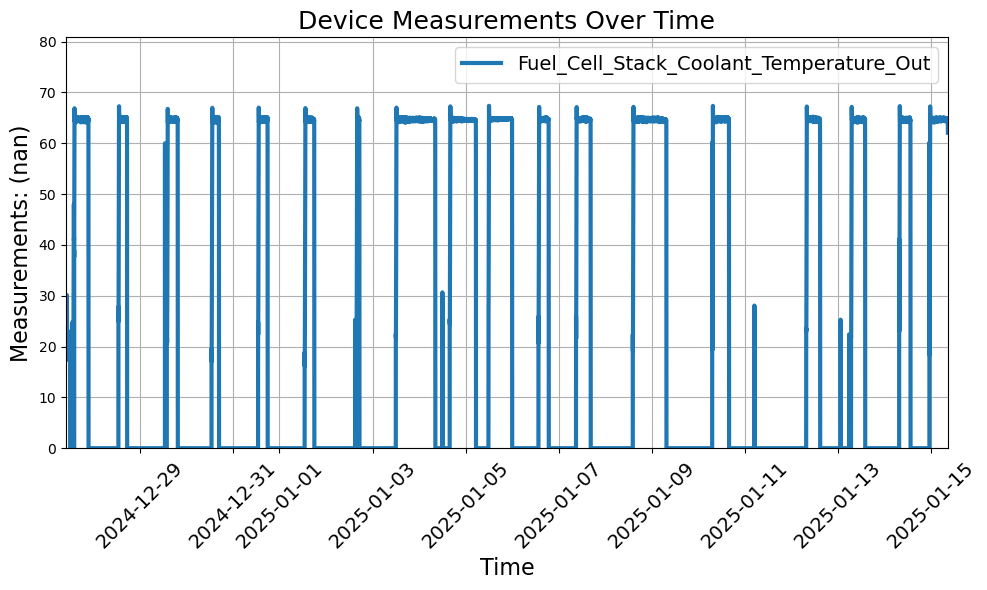

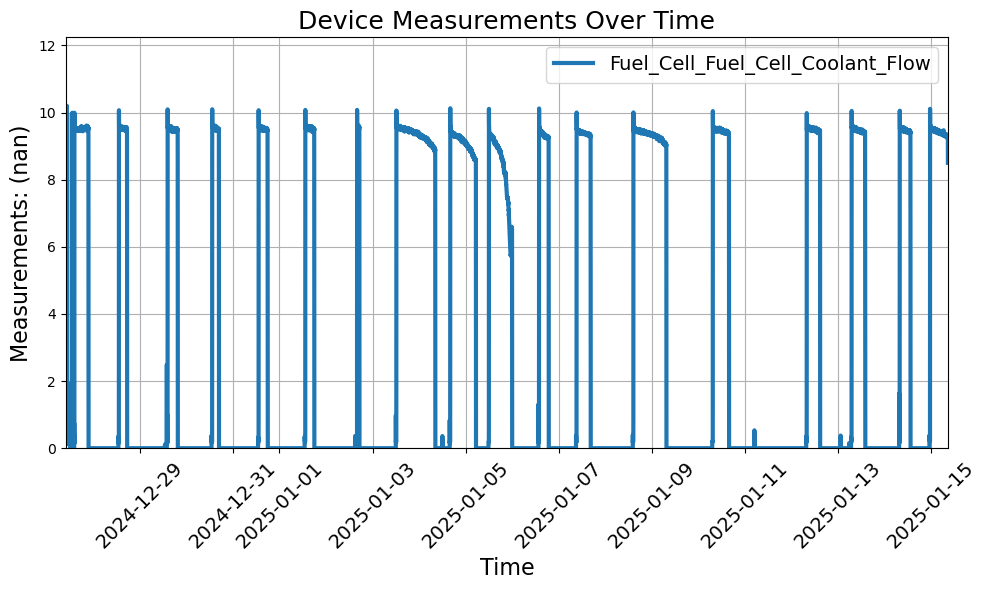

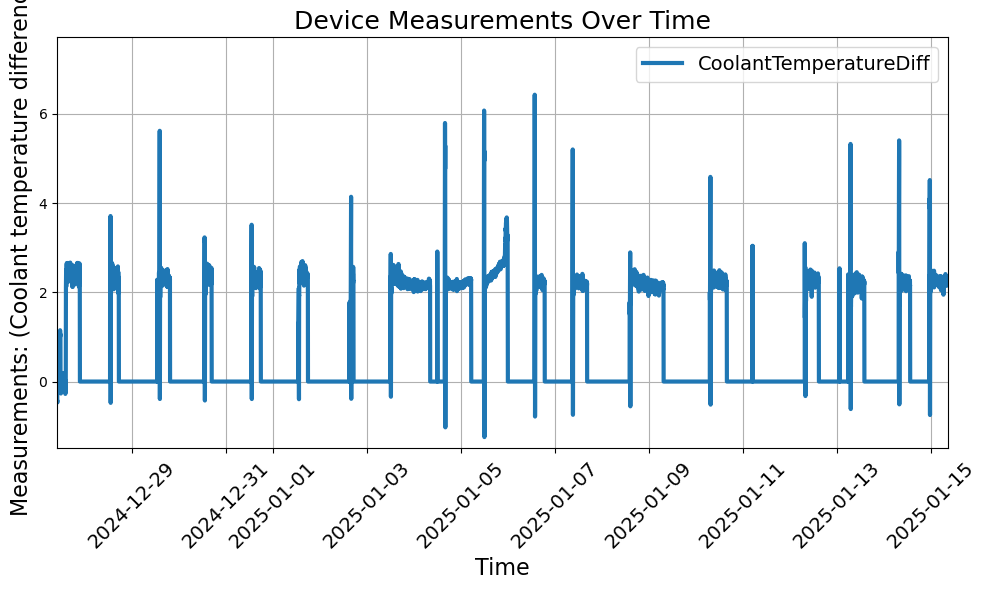

Maximum Thermal Power 1785.36 W
Maximum Thermal Stack Power 2625.98 W


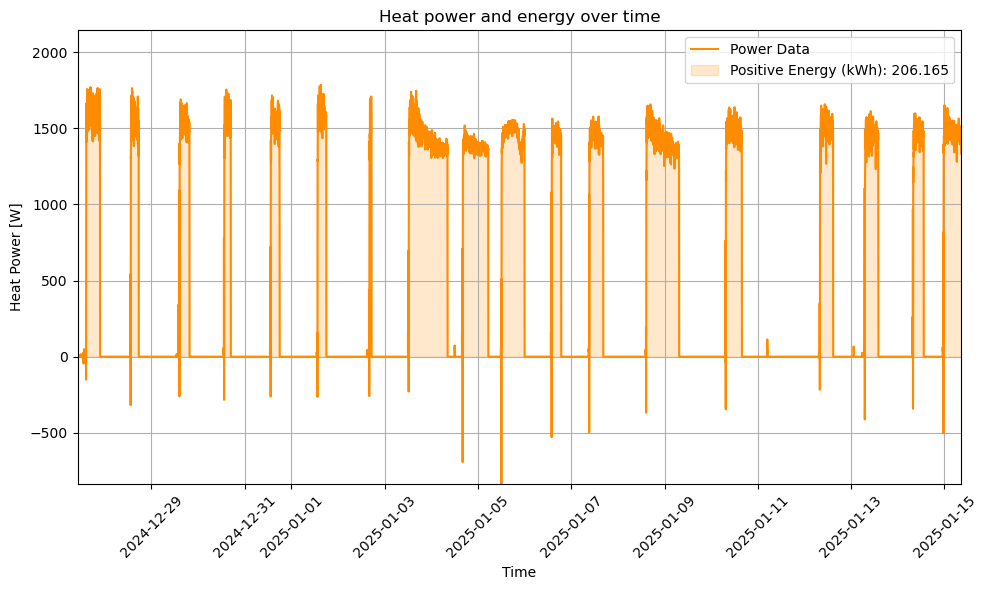

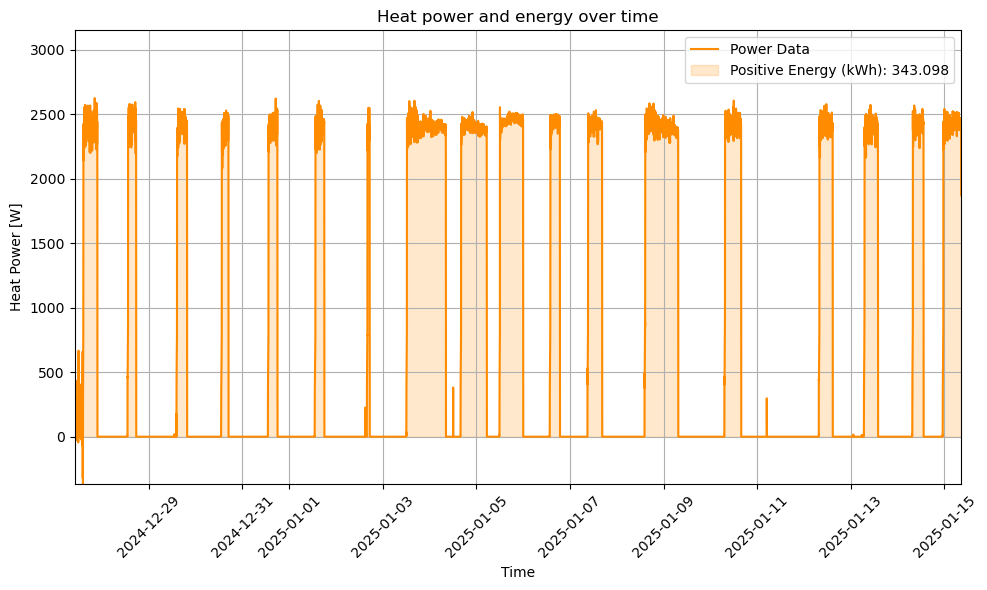


Total thermal energy that can be extracted: 205.95 kWh
Total thermal energy form the stack that can be extracted: 343.07 kWh



In [56]:
fplot("Fuel_Cell_Stack_Coolant_Temperature_Out")
fplot("Fuel_Cell_Fuel_Cell_Coolant_Flow")

densityWater = 1000  # kg/m^3 for water
SpecificHeatWater = 4186  # J/(kg·°C) for water (adjust if using different coolant)

CoolantTemperatureDiff = pd.DataFrame({ # Make a DF that works with my scripts
        'time': pd.to_datetime(Fuel_Cell_Stack_Coolant_Temperature_Out['time']),  # Converts to datetime objectdf['validdate'],
        'value_float': 0,
        'device_id': 'Fuel_Cell',
        'measurement_id': 'Coolant temperature difference'
        })

CoolantTemperatureStackDiff = pd.DataFrame({ # Make a DF that works with my scripts
        'time': pd.to_datetime(Fuel_Cell_Stack_Coolant_Temperature_Out['time']),  # Converts to datetime objectdf['validdate'],
        'value_float': 0,
        'device_id': 'Fuel_Cell',
        'measurement_id': 'Coolant temperature difference'
        })

CoolantFlowrate = pd.DataFrame({ # Make a DF that works with my scripts
        'time': pd.to_datetime(Fuel_Cell_Fuel_Cell_Coolant_Flow['time']),  # Converts to datetime objectdf['validdate'],
        'value_float': 0,
        'device_id': 'Fuel_Cell',
        'measurement_id': 'Coolant Flow Rate [L/min]'
        })

StackCoolantFlowrate = pd.DataFrame({ # Make a DF that works with my scripts
        'time': pd.to_datetime(Fuel_Cell_Stack_Coolant_Flow['time']),  # Converts to datetime objectdf['validdate'],
        'value_float': 0,
        'device_id': 'Fuel_Cell',
        'measurement_id': 'Coolant Flow Rate [L/min]'
        })

ThermalEnergy = pd.DataFrame({ # Make a DF that works with my scripts
        'time': pd.to_datetime(Fuel_Cell_Stack_Coolant_Flow['time']),  # Converts to datetime objectdf['validdate'],
        'value_float': 0,
        'device_id': 'Fuel_Cell',
        'measurement_id': 'Thermal energy [J]'
        })

ThermalEnergyStack = pd.DataFrame({ # Make a DF that works with my scripts
        'time': pd.to_datetime(Fuel_Cell_Stack_Coolant_Flow['time']),  # Converts to datetime objectdf['validdate'],
        'value_float': 0,
        'device_id': 'Fuel_Cell',
        'measurement_id': 'Thermal energy [J]'
        })


CoolantTemperatureDiff['value_float'] = Fuel_Cell_Fuel_Cell_Coolant_Temperature_Out['value_float'] - Fuel_Cell_Fuel_Cell_Coolant_Temperature_In['value_float']
CoolantTemperatureStackDiff['value_float'] = Fuel_Cell_Stack_Coolant_Temperature_Out['value_float'] - Fuel_Cell_Stack_Coolant_Temperature_In['value_float']

fplot("CoolantTemperatureDiff")
# Liters/min, convert it to kg/s (1 liter = 1 kg for water)
CoolantFlowrate['value_float'] = Fuel_Cell_Fuel_Cell_Coolant_Flow['value_float'] * densityWater / (60*1000)  # flow: L/min, to in kg/s
StackCoolantFlowrate['value_float'] = Fuel_Cell_Stack_Coolant_Flow['value_float'] * densityWater / (60*1000)  # flow: L/min, to in kg/s

ThermalEnergy['value_float'] = CoolantFlowrate['value_float'] * SpecificHeatWater * CoolantTemperatureDiff['value_float'] # kg/s * J/kgC * C makes J/s or W
ThermalEnergyStack['value_float'] = StackCoolantFlowrate['value_float'] * SpecificHeatWater * CoolantTemperatureStackDiff['value_float']

print(f"Maximum Thermal Power {ThermalEnergy['value_float'].max():.2f} W")
print(f"Maximum Thermal Stack Power {ThermalEnergyStack['value_float'].max():.2f} W")

TothermalEnergy = integrate_heat('ThermalEnergy')[0]
TothermalEnergyStack = integrate_heat('ThermalEnergyStack')[0]
print()
print(f"Total thermal energy that can be extracted: {TothermalEnergy:.2f} kWh")
print(f"Total thermal energy form the stack that can be extracted: {TothermalEnergyStack:.2f} kWh")
print()


### MPPT VS Inverter VS Stack efficiencies
Data for the MPPT converter, Inverter, and Stack on current and voltage is gathered. This way each of their efficiencies can be calculated.


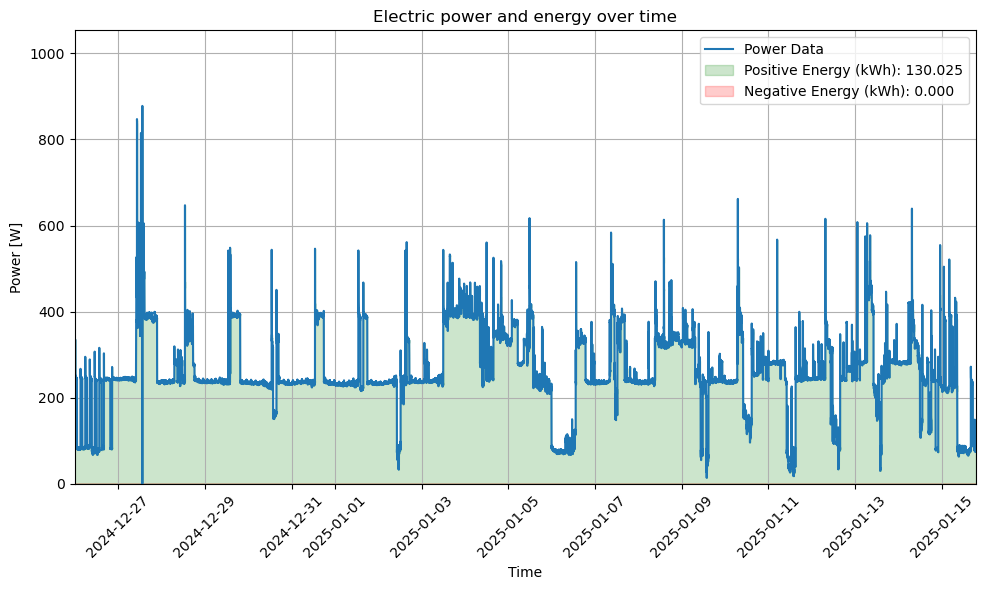

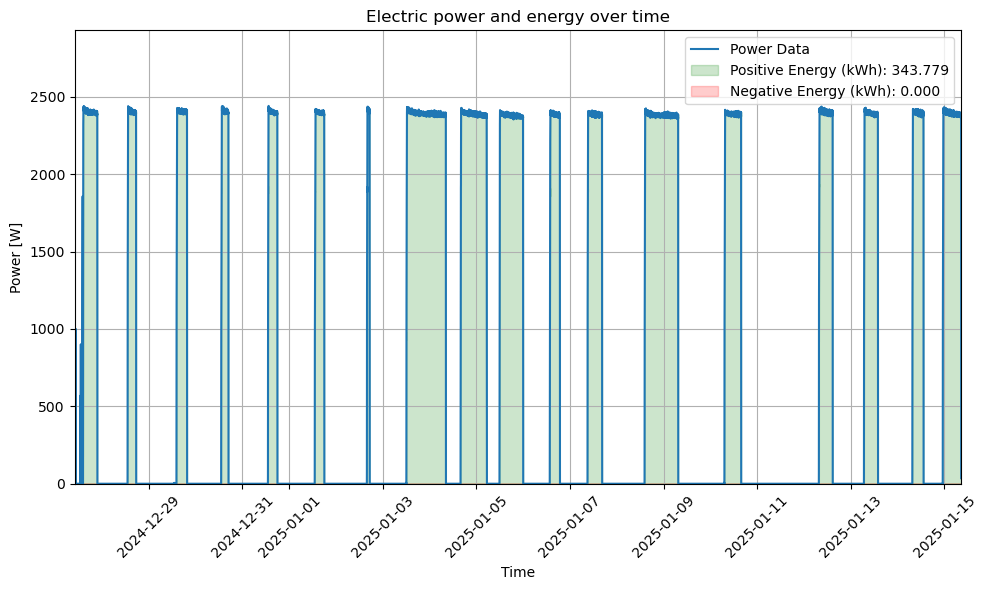

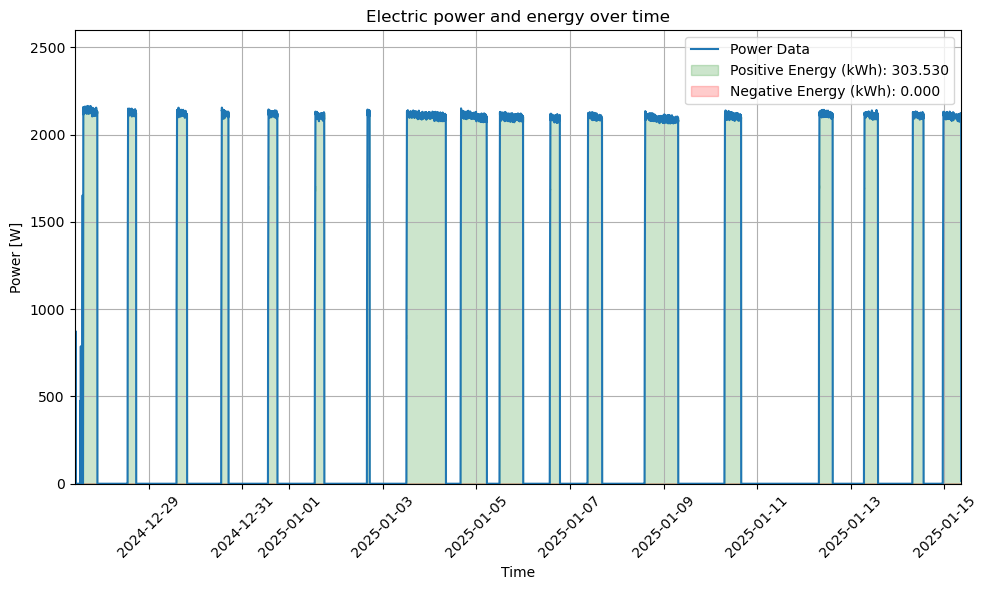

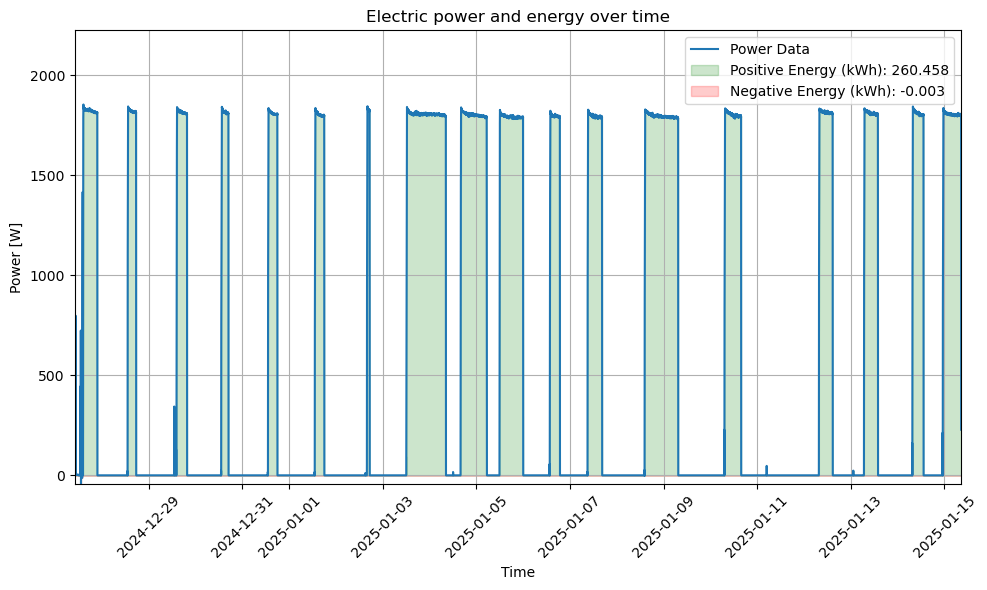

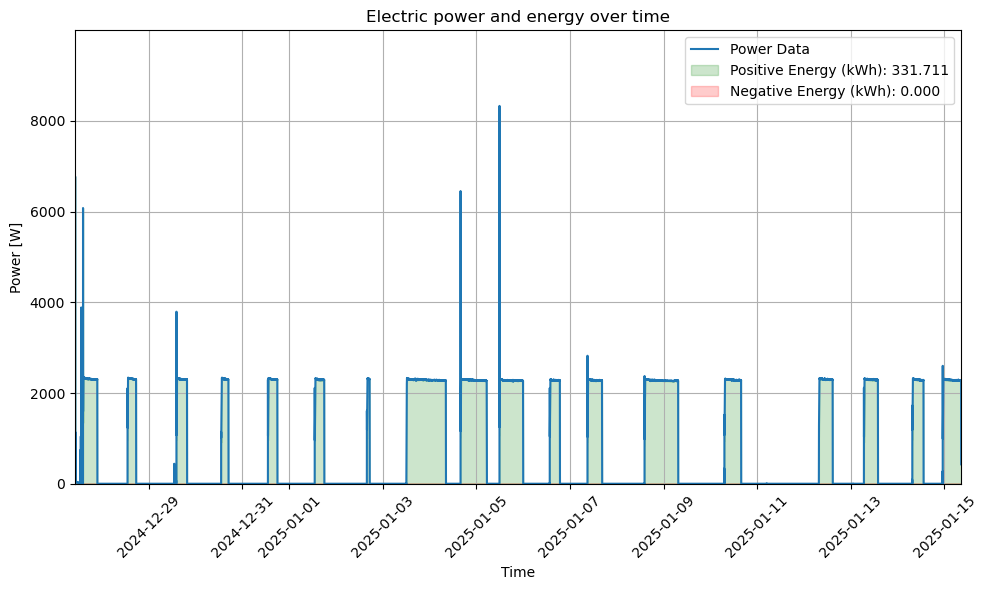

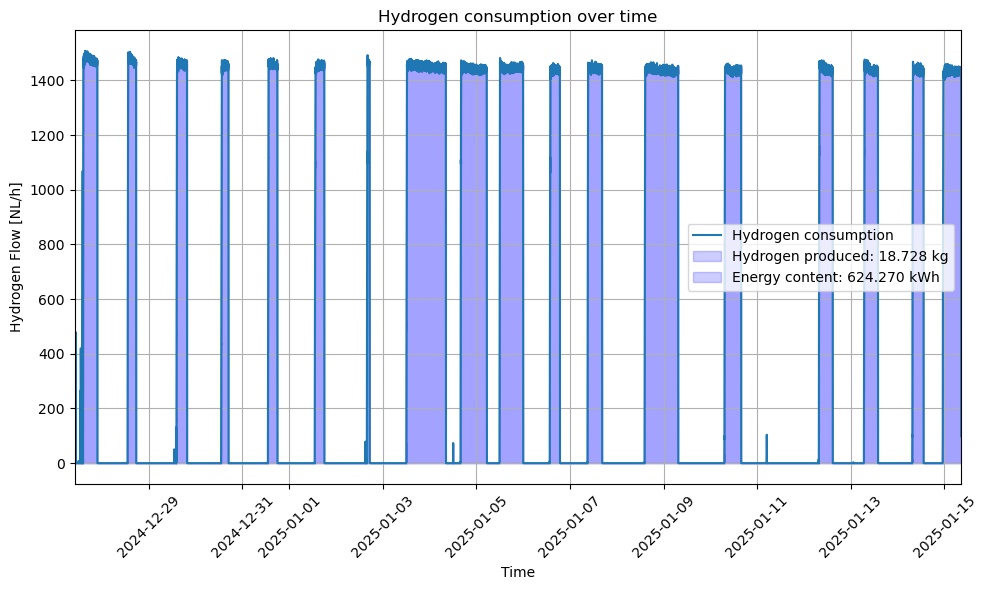

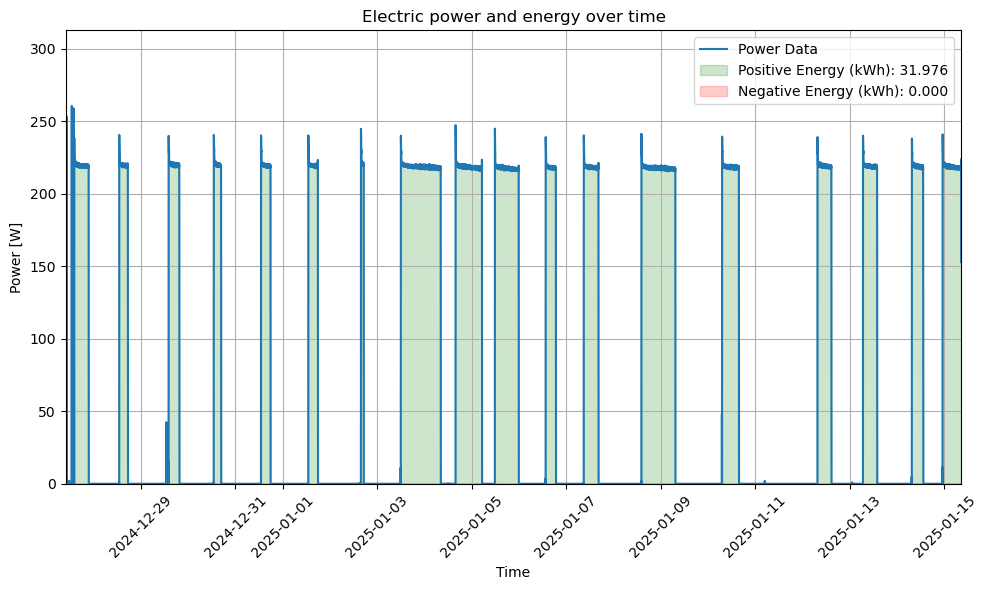

Stack to MPPT efficiency: 88.29 %
MPPT to inverter efficiency: 95.91 %
Stack to inverter electrical efficiency: 83.53 %
Stack to inverter electrical efficiency & BoP: 37.94 %

Hydrogen to Stack efficiency: 55.07 %
Hydrogen to MPPT efficiency: 48.62 %
Hydrogen to inverter efficiency: 41.72 %
Hydrogen to inverter & BoP efficiency: 20.89 %

Energy used by DC blower: 31.98 [kWh]


In [58]:
# We start with stack DC to MPPT DC:
Fuel_Cell_Stack_Power = pd.DataFrame({ 
        'time': pd.to_datetime(Fuel_Cell_Stack_DC_Current['time']),
        'value_float': 0,
        'device_id': 'Fuel_Cell',
        'measurement_id': 'Stack_Power'
        })

Fuel_Cell_MPPT_Power = pd.DataFrame({
        'time': pd.to_datetime(Fuel_Cell_MPPT_Output_Voltage['time']),
        'value_float': 0,
        'device_id': 'Fuel_Cell',
        'measurement_id': 'MPPT_Power'
        })

Fuel_Cell_Inverter_DC_Power = pd.DataFrame({
        'time': pd.to_datetime(Fuel_Cell_Inverter_DC_Voltage['time']),
        'value_float': 0,
        'device_id': 'Fuel_Cell',
        'measurement_id': 'Stack_Power'
        })

BlowerPower = pd.DataFrame({ 
        'time': pd.to_datetime(Fuel_Cell_Stack_DC_Current['time']),
        'value_float': 0,
        'device_id': 'Fuel_Cell',
        'measurement_id': 'DC_Blower'
        })

BlowerDCCurrent = pd.DataFrame({ 
        'time': pd.to_datetime(Fuel_Cell_Stack_DC_Current['time']),
        'value_float': 6.4,
        'device_id': 'Fuel_Cell',
        'measurement_id': 'DC_Blower'
        })

Fuel_Cell_Stack_Power['value_float'] =  Fuel_Cell_Stack_DC_Current['value_float']*Fuel_Cell_Stack_DC_Voltage['value_float']
Fuel_Cell_MPPT_Power['value_float'] =  Fuel_Cell_MPPT_Output_Current['value_float']*Fuel_Cell_MPPT_Output_Voltage['value_float']
Fuel_Cell_Inverter_DC_Power['value_float'] =  Fuel_Cell_Inverter_DC_Current['value_float']*Fuel_Cell_Inverter_DC_Voltage['value_float']+6.4*Fuel_Cell_Stack_DC_Voltage['value_float']
BlowerPower['value_float'] =  BlowerDCCurrent['value_float']*Fuel_Cell_Stack_DC_Voltage['value_float']



#Energy use by BoP
num_hours = (Fuel_Cell_Stack_DC_Current['time'].max() - Fuel_Cell_Stack_DC_Current['time'].min()).total_seconds() / 3600
EnergyBoP = 280*num_hours/1000;#integrate_hr("ACPowerOut")[0]

EnergyBoP = integrate_hr("Battery_Inverter_AC_Out_Power")[0]


EnergyStack = integrate_hr("Fuel_Cell_Stack_Power")[0]
EnergyMPPT = integrate_hr("Fuel_Cell_MPPT_Power")[0]
EnergyACInverter = integrate_hr("Fuel_Cell_Inverter_AC_Power")[0]
EnergyDCInverter = integrate_hr("Fuel_Cell_Inverter_DC_Power")[0]
EnergyH2 = integrate_h2("Fuel_Cell_Stack_Hydrogen_Inlet_Flow")[1]
EnergyBlower = integrate_hr("BlowerPower")[0]


print(f"Stack to MPPT efficiency: {EnergyMPPT/EnergyStack*100:.2f} %")
print(f"MPPT to inverter efficiency: {EnergyACInverter/(EnergyMPPT-EnergyBlower)*100:.2f} %")
print(f"Stack to inverter electrical efficiency: {EnergyACInverter/(EnergyStack-EnergyBlower)*100:.2f} %")
print(f"Stack to inverter electrical efficiency & BoP: {(EnergyACInverter-EnergyBoP)/EnergyStack*100:.2f} %")
print()
print(f"Hydrogen to Stack efficiency: {EnergyStack/EnergyH2*100:.2f} %")
print(f"Hydrogen to MPPT efficiency: {EnergyMPPT/EnergyH2*100:.2f} %")
print(f"Hydrogen to inverter efficiency: {EnergyACInverter/EnergyH2*100:.2f} %")
print(f"Hydrogen to inverter & BoP efficiency: {(EnergyACInverter-EnergyBoP)/EnergyH2*100:.2f} %")
print()
print(f"Energy used by DC blower: {EnergyBlower:.2f} [kWh]")



In [28]:
# Some extra information is extracted:
duration = Battery_Inverter_AC_Out_Power['time'].max() - Battery_Inverter_AC_Out_Power['time'].min()
print(duration)
duration_hours = duration.total_seconds() / 3600  # Convert seconds to hours

AvgPower = EnergyBoP/duration_hours
print(f"Average power of BoP is {AvgPower*1000:.2f} [W]")


20 days 19:00:00
Average power of BoP is 260.57 [W]


### A Closer Look

Now a closer look is taken at the fuel cell. We start with selecting one day in which the fuel cell was operational, and we zoom in to ramping up and down.

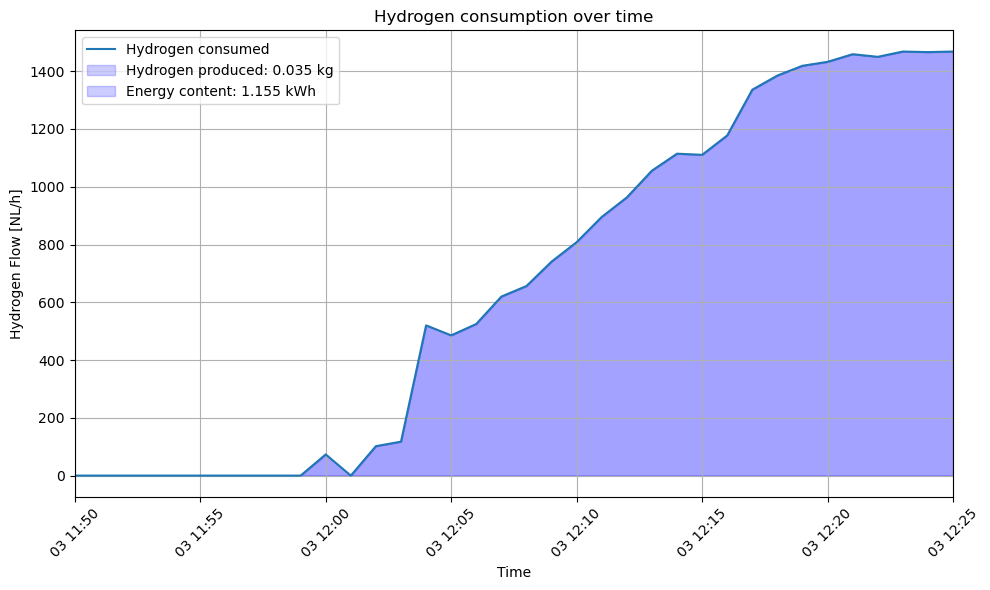

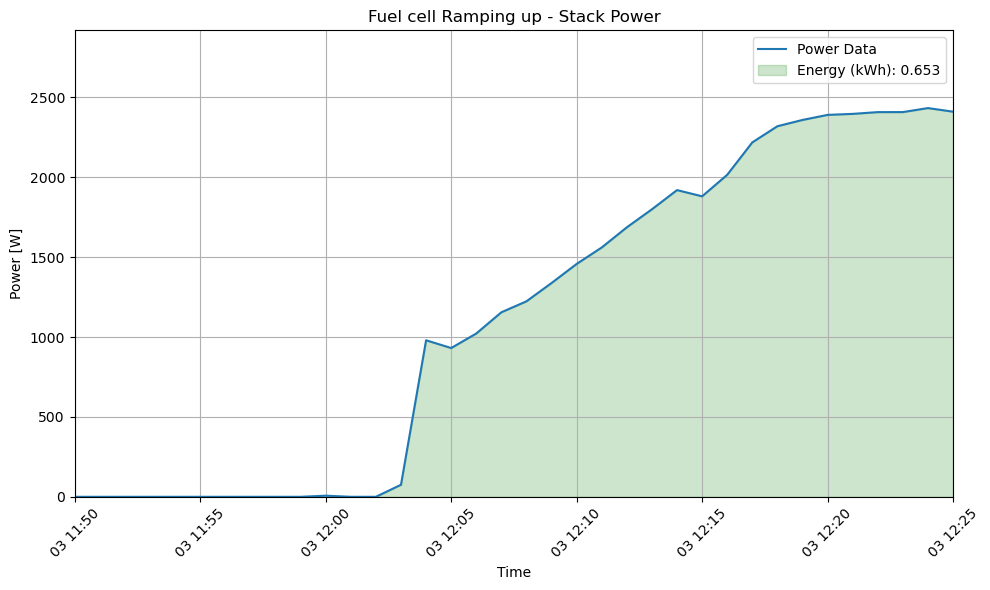

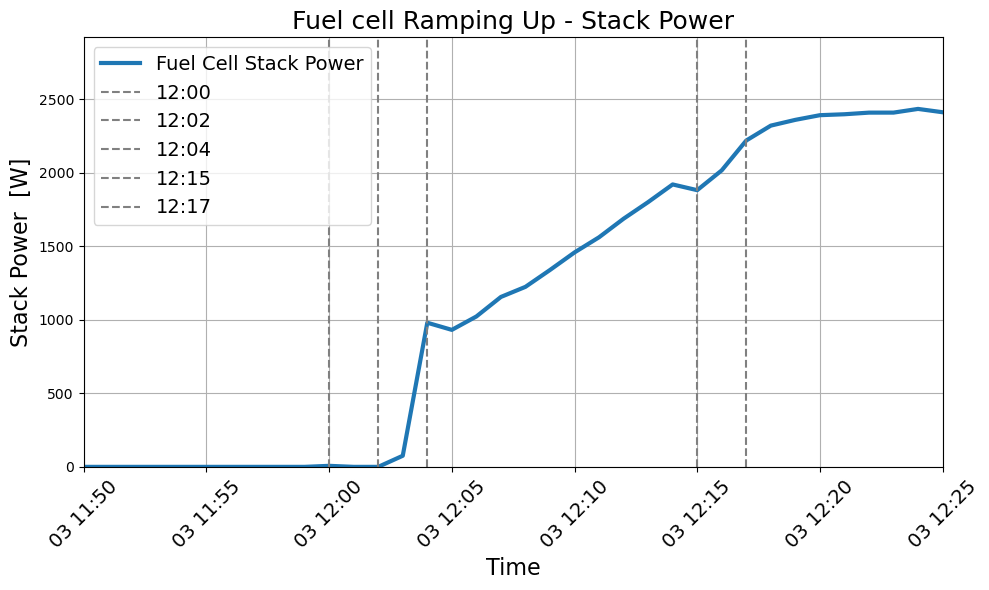

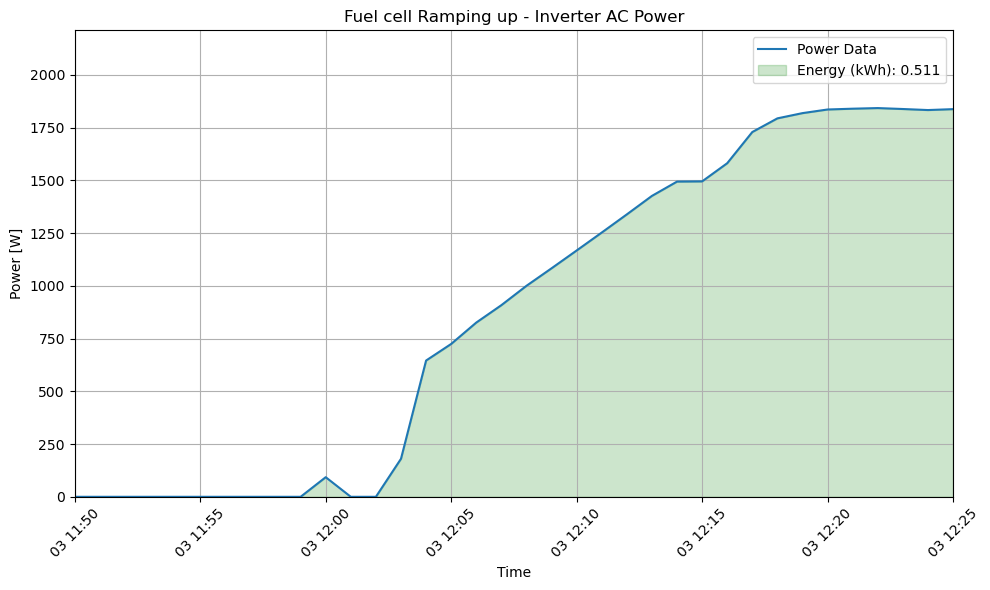

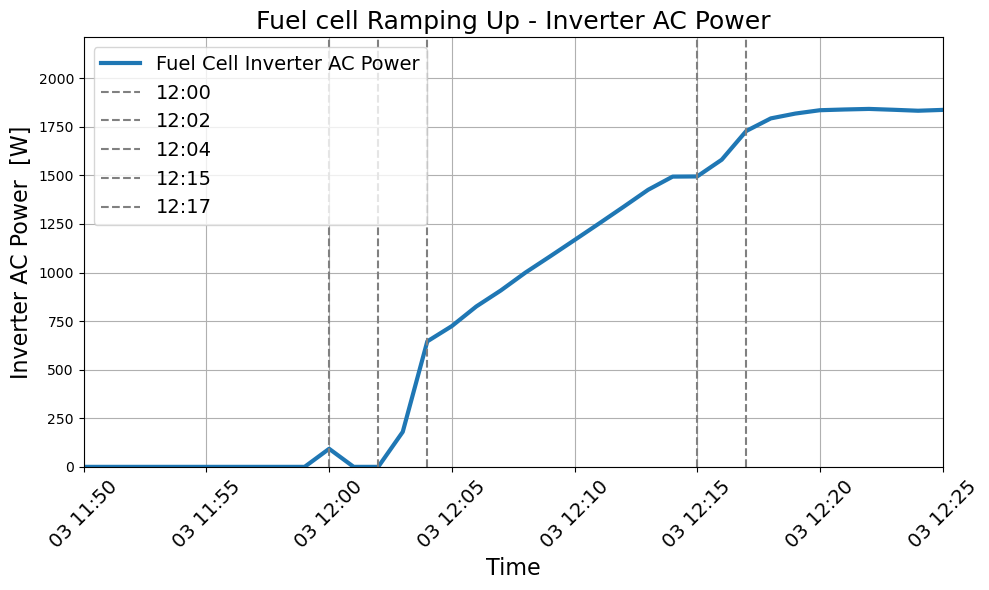

In [52]:
def fplotup(*vars):
    minval = maxval = 0
    measurement_types = set()
    plt.figure(figsize=figdim)
    for var in vars:
        if var in globals():

            times = ["2025-01-03 12:00:00", "2025-01-03 12:02:00", "2025-01-03 12:04:00", "2025-01-03 12:15:00", "2025-01-03 12:17:00"]
            labels = ["12:00", "12:02", "12:04", "12:15", "12:17"]
            x_times = pd.to_datetime(times)

            data = globals()[var] # Needed to recall the data from their string name
            device_measurement_label = f"{data['device_id'].iloc[0]} - {data['measurement_id'].iloc[0]}"
            plt.plot(data['time'], data['value_float'], marker='', linestyle='-',linewidth = 3, label=var[:-8].replace("_", " "))

            for x, label in zip(x_times, labels):
                plt.axvline(x=x, color='grey', linestyle='--', label=label, linewidth=1.5)
            measurement_types.add(data['measurement_id'].iloc[0])

            #Determines size needed of the canvas (surely could be improved)
            if minval > min(data['value_float']):
                minval = min(data['value_float'])
            if maxval < max(data['value_float']):
                maxval = max(data['value_float'])
        else:
            print(f"Variable '{var}' not found!")
    measurement = measurement_types.pop().replace("_", " ")
    # Fixes labeling for multiple features to be plotted in one figure
     # Plotting settings:
    unit = ""
    if "power" in var.lower():
        unit = " [W]"  # Watts
    elif "temperature" in var.lower():
        unit = " [°C]"  # Degrees Celsius
    elif "current" in var.lower():
        unit = " [A]"  # Amperes
    elif "voltage" in var.lower():
        unit = " [V]"  # Volts
    elif "pressure" in var.lower():
        unit = " [bar]"  # Pressure
    elif "flow" in var.lower():
        unit = " [L/min]"  # flow
    plt.ylabel(f"{measurement} {unit}", fontsize=label_fontsize)

   
        
    plt.xlabel('Time', fontsize=label_fontsize)
 #  plt.ylabel(f'Value {data['measurement_id']}', fontsize=label_fontsize)
    plt.xlim(min(data['time']), max(data['time']))
    plt.ylim(minval*1.2, maxval*1.2)
    plt.title(f'Fuel cell Ramping Up - {measurement}',fontsize=title_fontsize)
    plt.xticks(rotation=45, fontsize=tick_fontsize)
    plt.tight_layout()
    plt.legend(fontsize=legend_fontsize)
    plt.grid(True)
    plt.show()


def fplotdown(*vars):
    minval = maxval = 0
    measurement_types = set()
    plt.figure(figsize=figdim)
    for var in vars:
        if var in globals():

            times = ["2025-01-04 08:17:00", "2025-01-04 08:18:00", "2025-01-04 08:19:00"]
            labels = ["08:17", "08:18", "08:19"]
            x_times = pd.to_datetime(times)

            data = globals()[var] # Needed to recall the data from their string name
            device_measurement_label = f"{data['device_id'].iloc[0]} - {data['measurement_id'].iloc[0]}"
            plt.plot(data['time'], data['value_float'], marker='', linestyle='-',linewidth = 3, label=var[:-8].replace("_", " "))

            for x, label in zip(x_times, labels):
                plt.axvline(x=x, color='grey', linestyle='--', label=label, linewidth=1.5)
            measurement_types.add(data['measurement_id'].iloc[0])

            #Determines size needed of the canvas (surely could be improved)
            if minval > min(data['value_float']):
                minval = min(data['value_float'])
            if maxval < max(data['value_float']):
                maxval = max(data['value_float'])
        else:
            print(f"Variable '{var}' not found!")
    measurement = measurement_types.pop().replace("_", " ")
    # Fixes labeling for multiple features to be plotted in one figure
     # Plotting settings:
    unit = ""
    if "power" in var.lower():
        unit = " [W]"  # Watts
    elif "temperature" in var.lower():
        unit = " [°C]"  # Degrees Celsius
    elif "current" in var.lower():
        unit = " [A]"  # Amperes
    elif "voltage" in var.lower():
        unit = " [V]"  # Volts
    elif "pressure" in var.lower():
        unit = " [bar]"  # Pressure
    elif "flow" in var.lower():
        unit = " [L/min]"  # flow
    plt.ylabel(f"{measurement} {unit}", fontsize=label_fontsize)

   
        
    plt.xlabel('Time', fontsize=label_fontsize)
 #  plt.ylabel(f'Value {data['measurement_id']}', fontsize=label_fontsize)
    plt.xlim(min(data['time']), max(data['time']))
    plt.ylim(minval*1.2, maxval*1.2)
    plt.title(f'Fuel cell Ramping Down - {measurement}',fontsize=title_fontsize)
    plt.xticks(rotation=45, fontsize=tick_fontsize)
    plt.tight_layout()
    plt.legend(fontsize=legend_fontsize)
    plt.grid(True)
    plt.show()


def integrate_hr_up(var):
    if var in globals():
        data = globals()[var]
        time = data['time']
        values = data['value_float']
        time_numeric = (time - time.iloc[0]).dt.total_seconds().astype(int)
        
        # We seperate positive and negative data in case power can be negative and positive (Battery)
        positive_values = np.where(values > 0, values, 0)
        negative_values = np.where(values < 0, values, 0)
        kWh_pos = np.trapz(positive_values, time_numeric)/3600000 # Perform integration for positive values
        joules = np.trapz(values, time_numeric)
        energy_kWh = joules / 3600000
    else:
        print(f"Variable '{var}' not found!")  
    measurement_types = set()
    measurement_types.add(data['measurement_id'].iloc[0])
    measurement = measurement_types.pop().replace("_", " ")

    plt.figure(figsize=figdim)
    plt.plot(time, values, label='Power Data')
    plt.fill_between(time, positive_values, alpha=0.2, label=f'Energy (kWh): {kWh_pos:.3f}', color='green')
    plt.xlabel('Time')
    plt.ylabel('Power [W]')
    plt.xlim(min(time),max(time))
    plt.ylim(min(values),max(values)*1.2)

    plt.title(f'Fuel cell Ramping up - {measurement}')
    plt.legend( loc='upper right')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return energy_kWh, kWh_pos

def integrate_h2_up(var):
  
    if var in globals():
        data = globals()[var]
        start_time = "2025-01-03 11:50:00"
        end_time = "2025-01-03 12:25:00"
        data = data[(data['time'] >= start_time) & (data['time'] <= end_time)]
        time = data['time']

        values = data['value_float']*60
        time_numeric = (time - time.iloc[0]).dt.total_seconds().astype(int)
        positive_values = np.where(values > 0, values, 0)
        H2pos = np.trapz(values, time_numeric) # Perform integration flow =  NL/min
    else:
        print(f"Variable '{var}' not found!")  
    
    H2Prod = H2Density*H2pos/(3600*1000) # H2 flow to kg
    EnergyH2 = LHV_H2*H2Prod/(3600*1000) # H2 flow to kWh(chem) (of H2)
    plt.figure(figsize=figdim)
    plt.plot(time, values, label='Hydrogen consumed')
    plt.fill_between(time, positive_values, alpha=0.2, label=f'Hydrogen produced: {H2Prod:.3f} kg', color='blue')
    plt.fill_between(time, positive_values, alpha=0.2, label=f'Energy content: {EnergyH2:.3f} kWh', color='blue')

    plt.xlabel('Time')
    plt.ylabel('Hydrogen Flow [NL/h]')
    plt.xlim(min(time),max(time))
    plt.title('Hydrogen consumption over time')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return H2Prod, EnergyH2
    
integrate_h2_up('Fuel_Cell_Stack_Hydrogen_Inlet_Flow')
trimrampup('Fuel_Cell_Stack_Power')
trimrampup('Fuel_Cell_Inverter_AC_Power')

Results for ramping up:
trimmed Fuel_Cell_Fuel_Cell_Coolant_Flow for ramping up below:


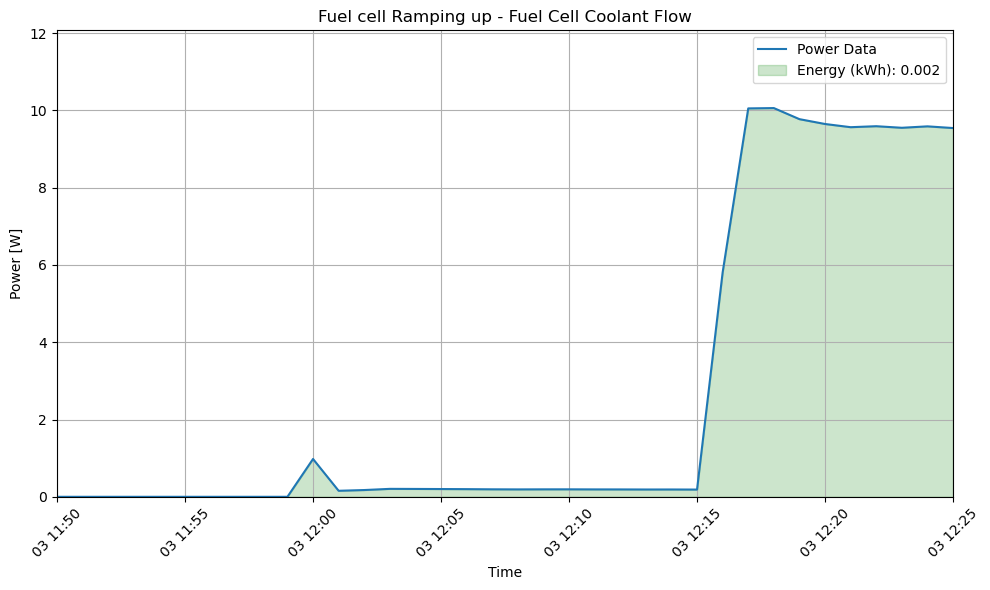

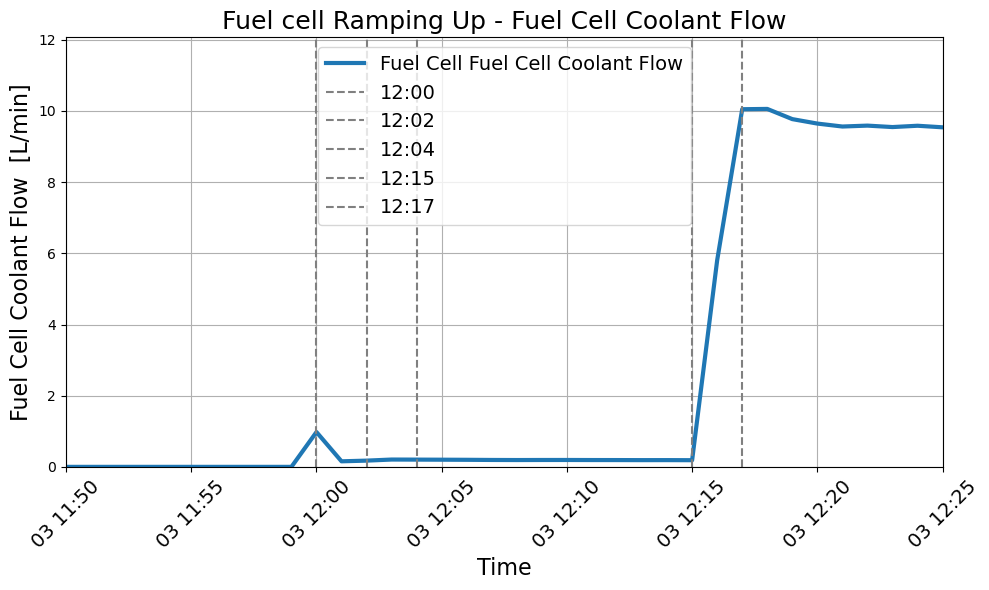

trimmed Fuel_Cell_Fuel_Cell_Coolant_Temperature_In for ramping up below:


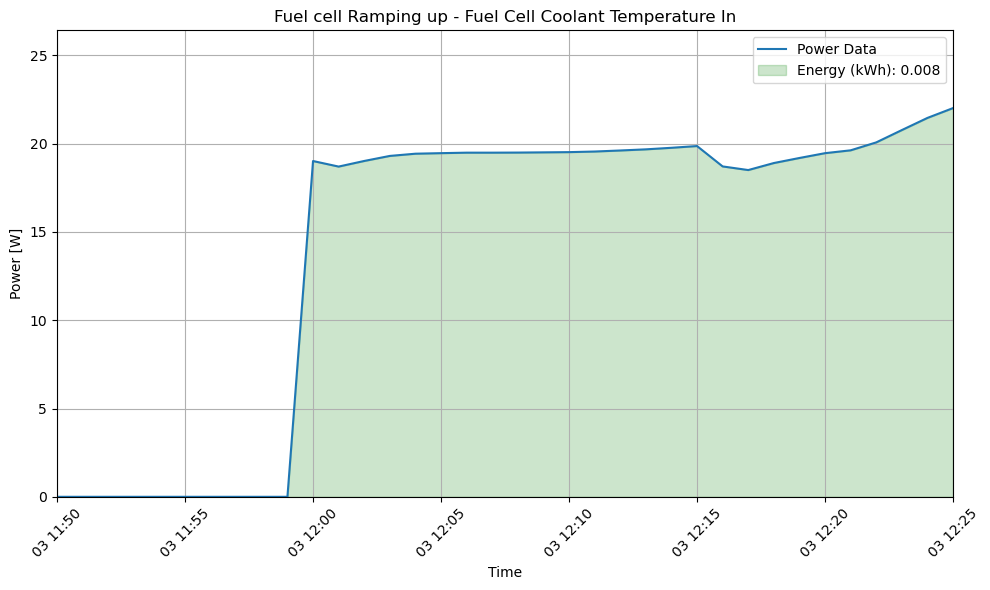

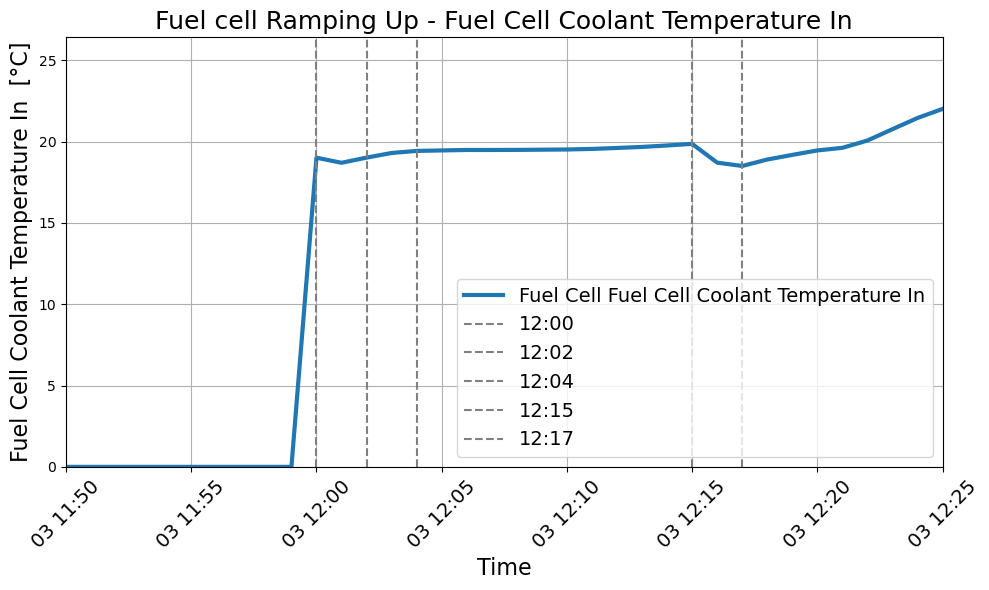

trimmed Fuel_Cell_Fuel_Cell_Coolant_Temperature_Out for ramping up below:


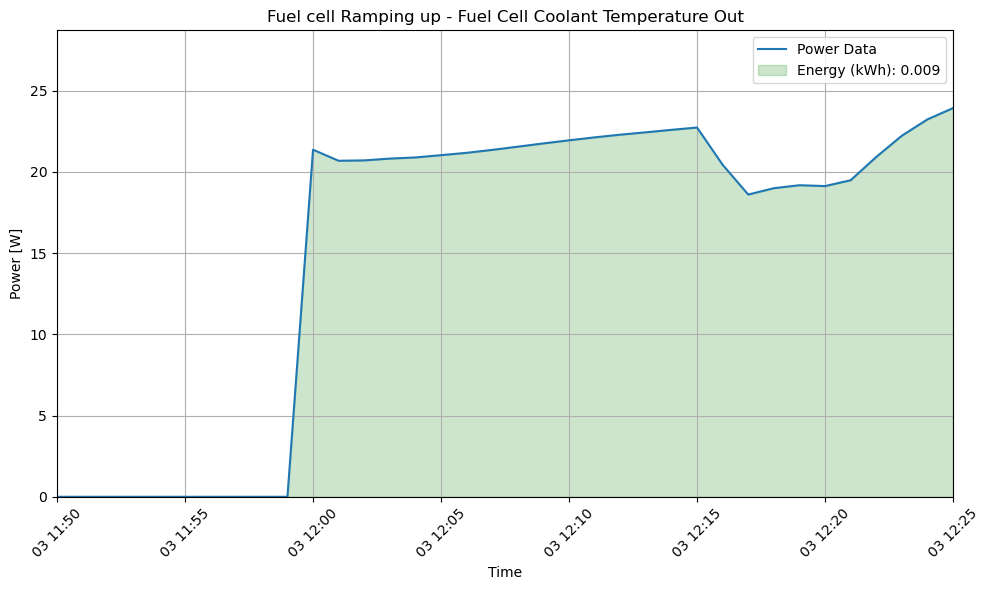

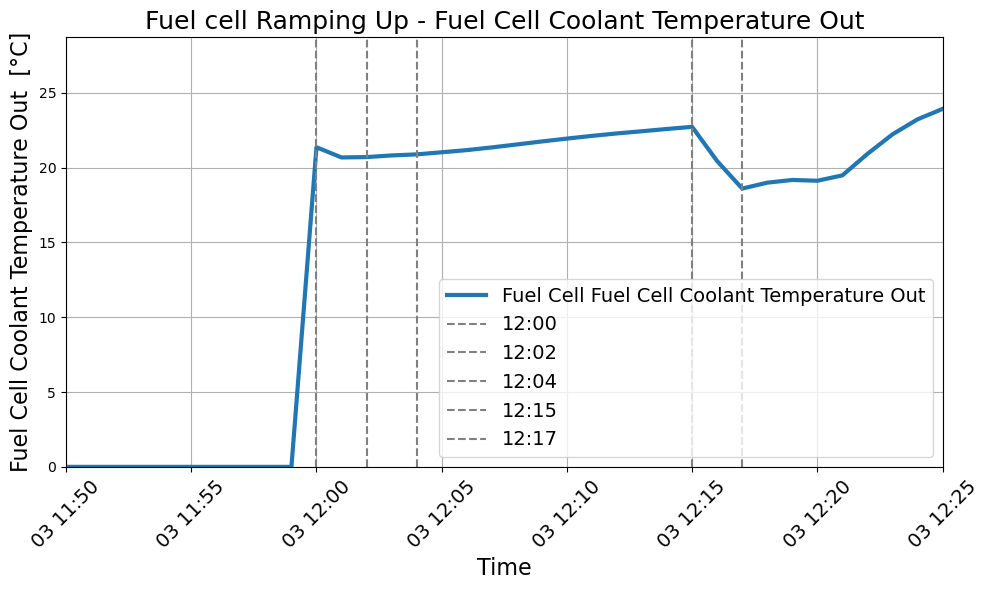

trimmed Fuel_Cell_Stack_Coolant_Flow for ramping up below:


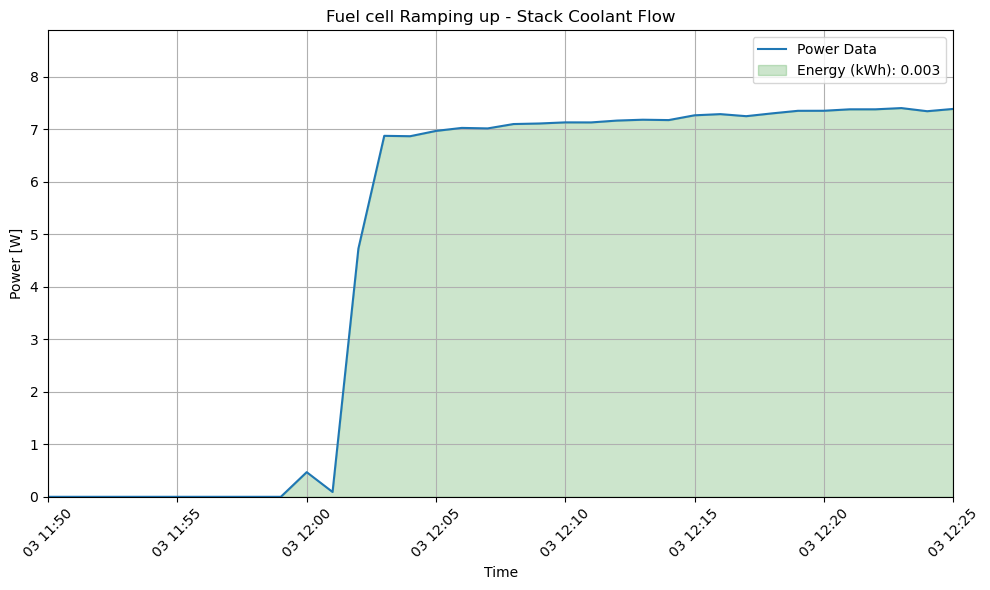

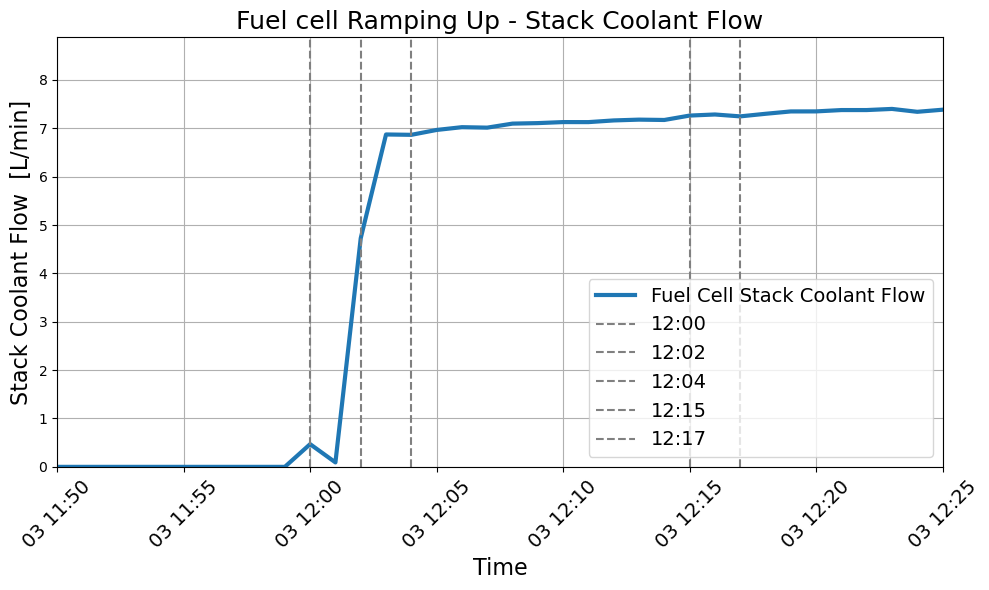

trimmed Fuel_Cell_Stack_Coolant_Temperature_In for ramping up below:


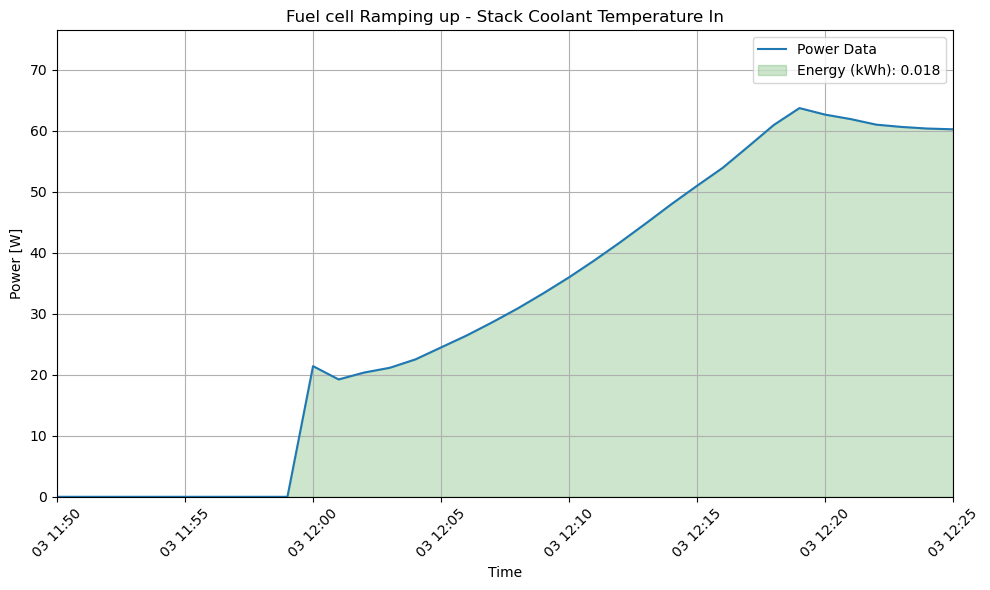

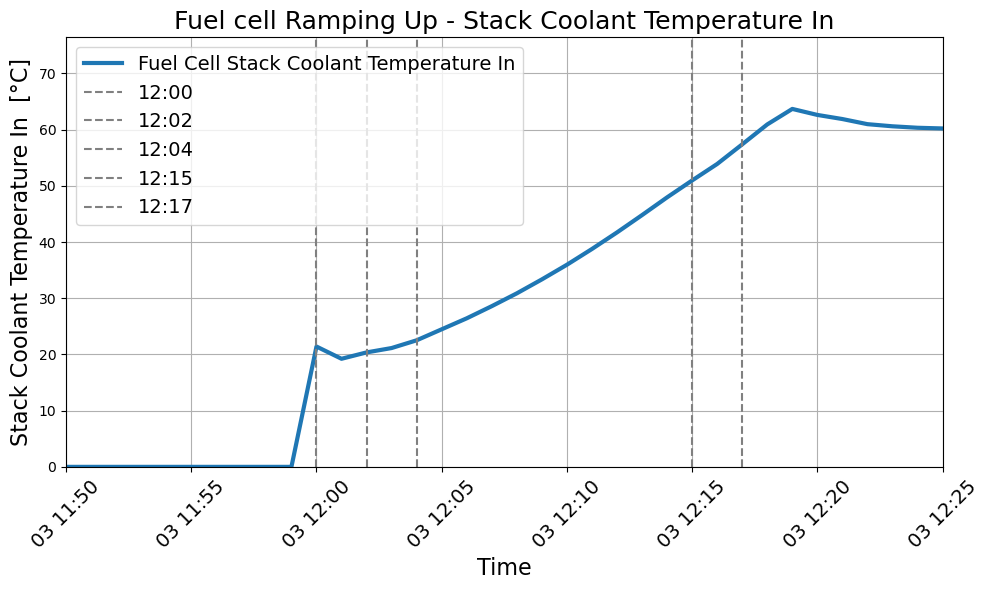

trimmed Fuel_Cell_Stack_Coolant_Temperature_Out for ramping up below:


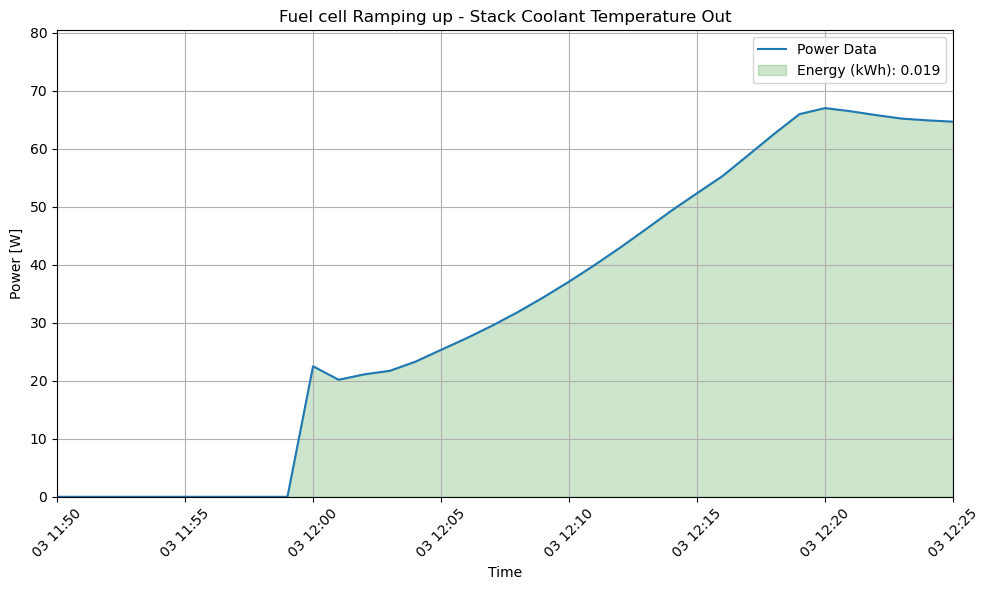

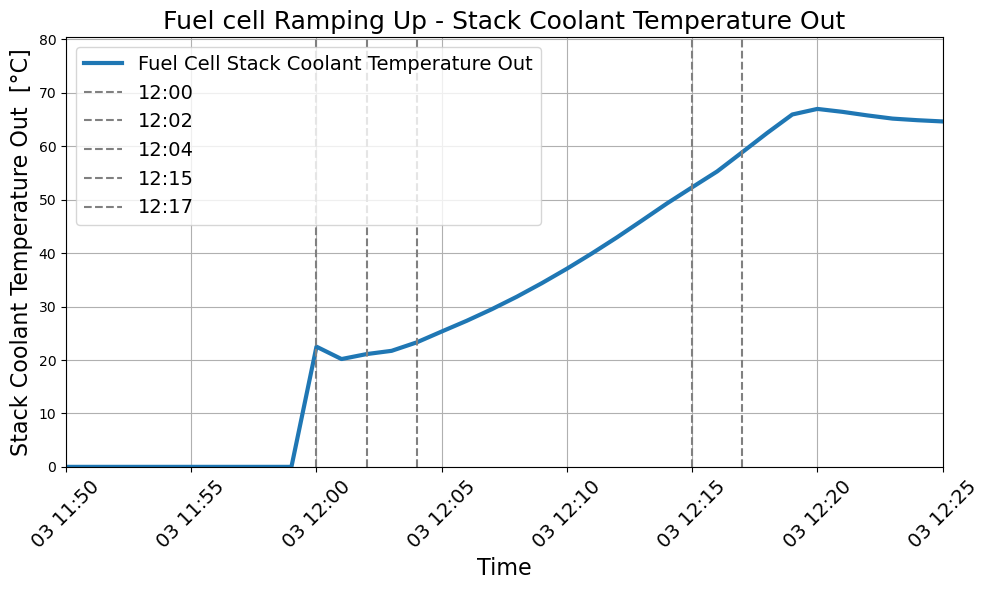

trimmed Fuel_Cell_Current_State for ramping up below:


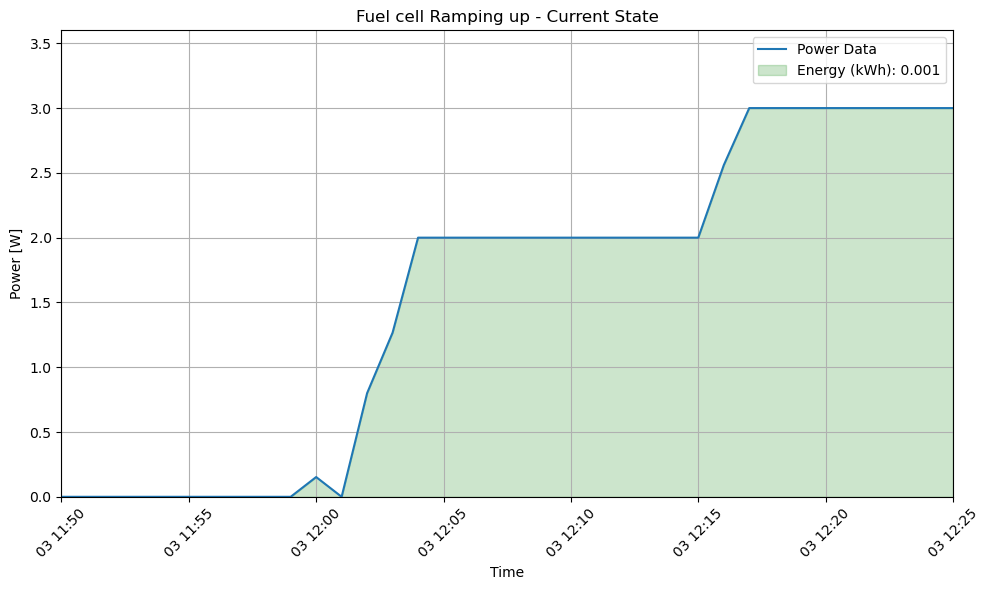

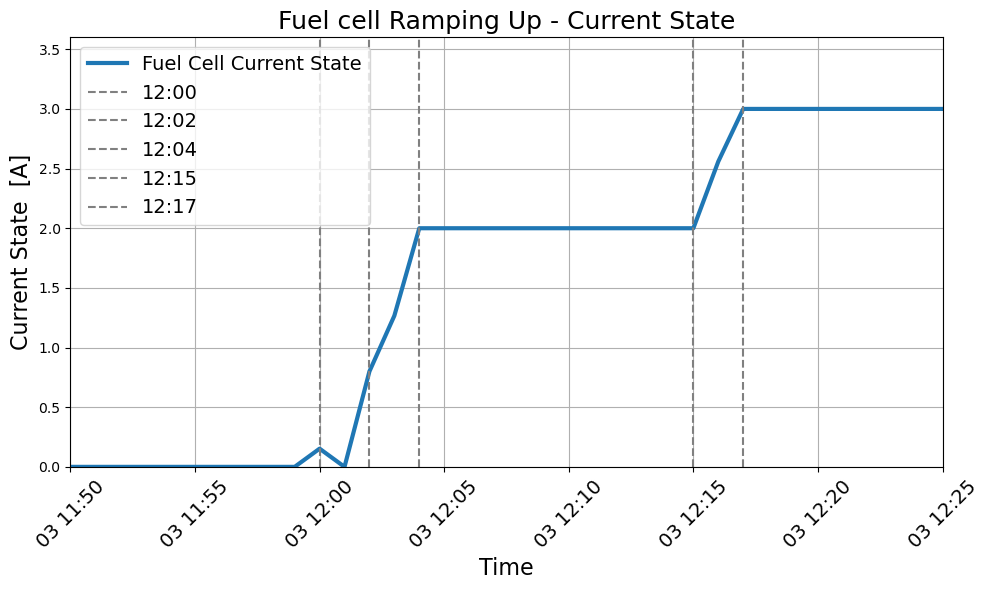

trimmed Pressure_Transmitter_State_Of_Charge for ramping up below:


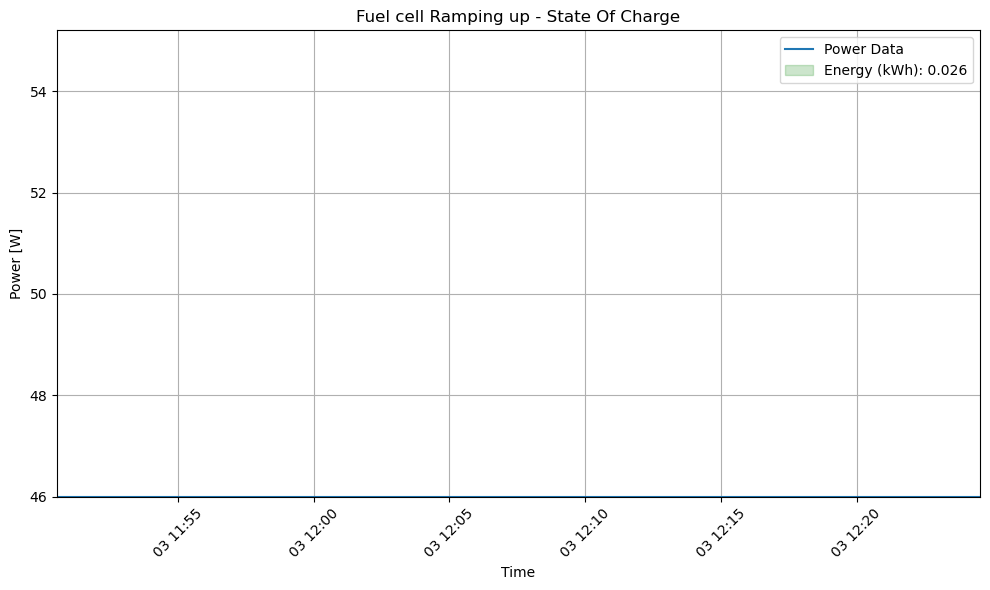

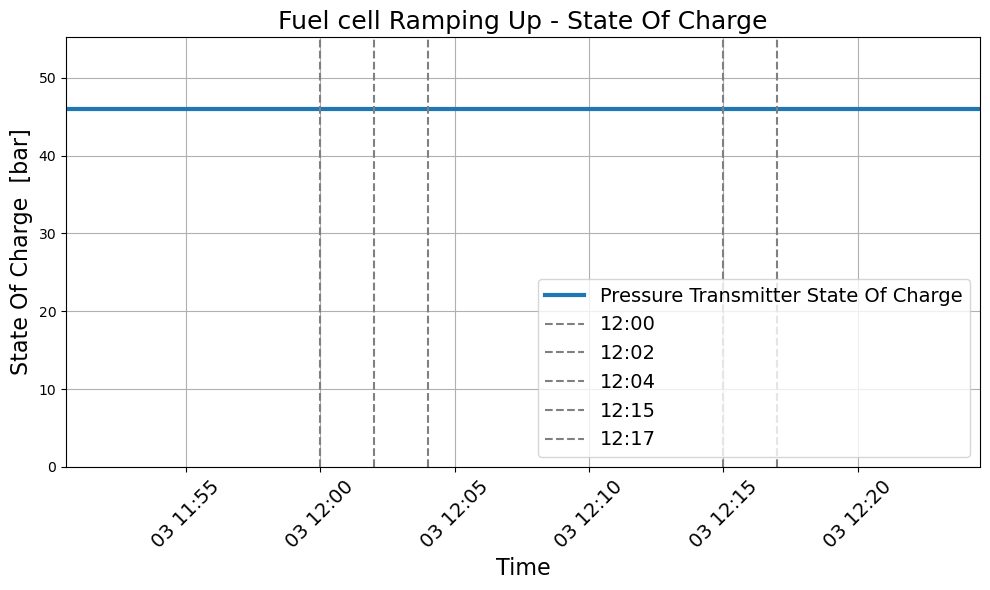

trimmed Battery_State_Of_Charge for ramping up below:


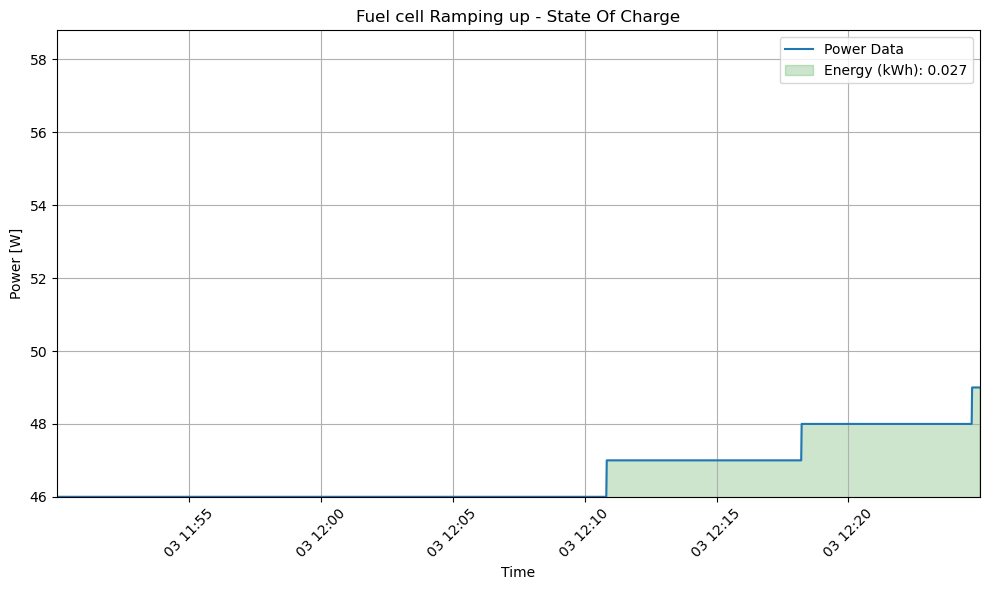

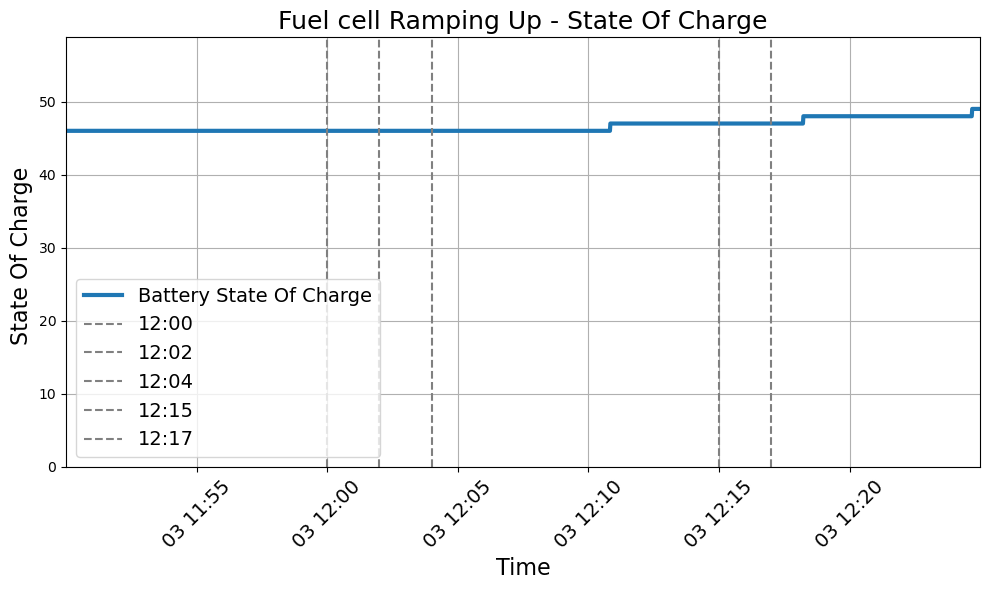

trimmed Fuel_Cell_Stack_Hydrogen_Pressure for ramping up below:


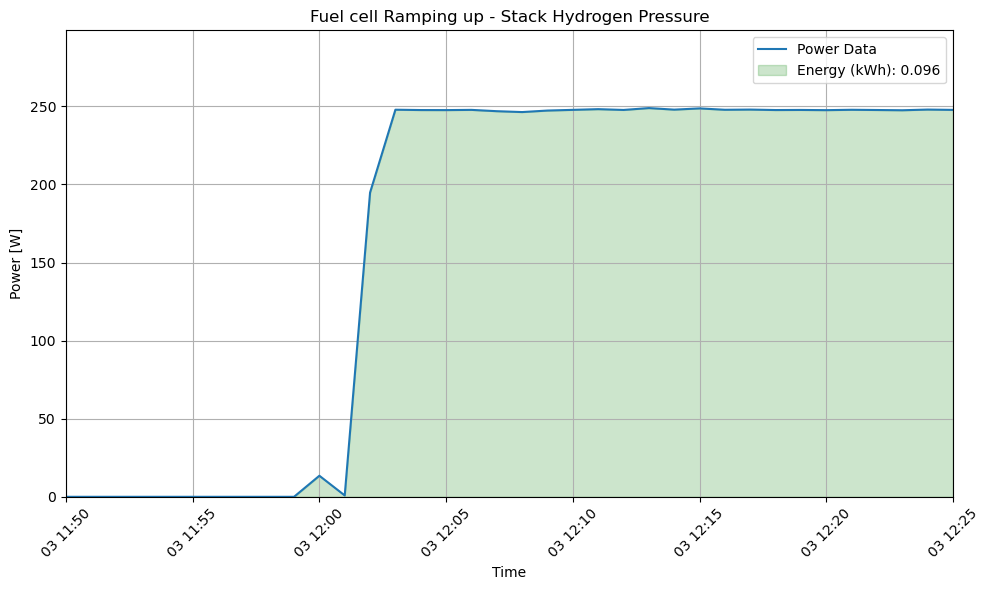

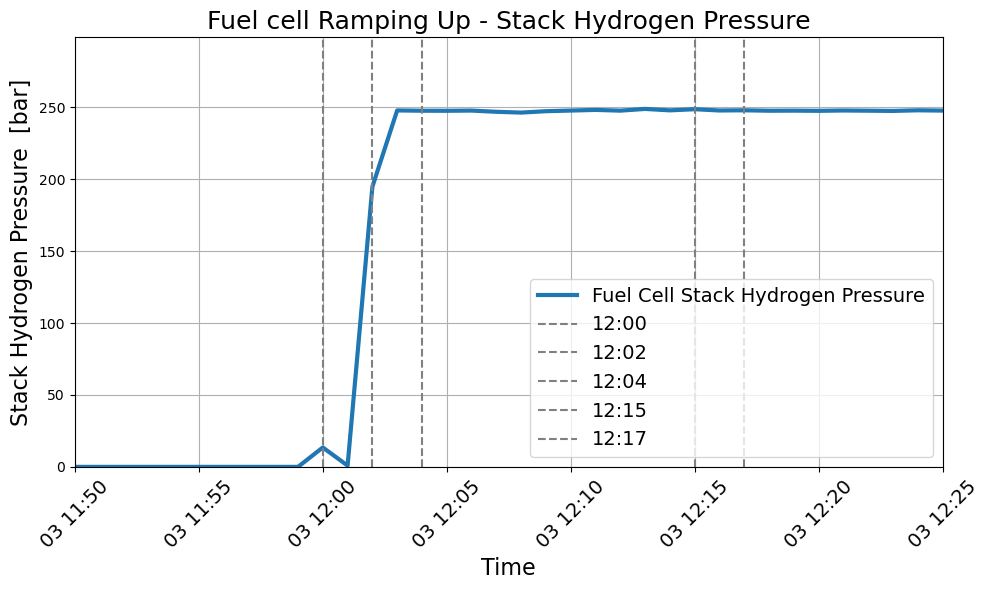

trimmed Fuel_Cell_Intermediate_Hydrogen_Pressure for ramping up below:


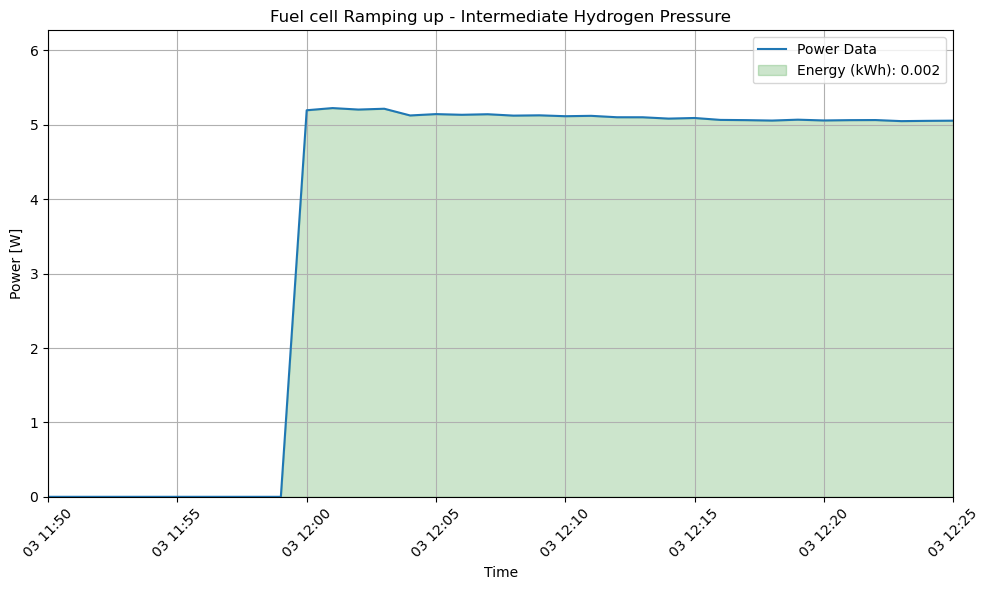

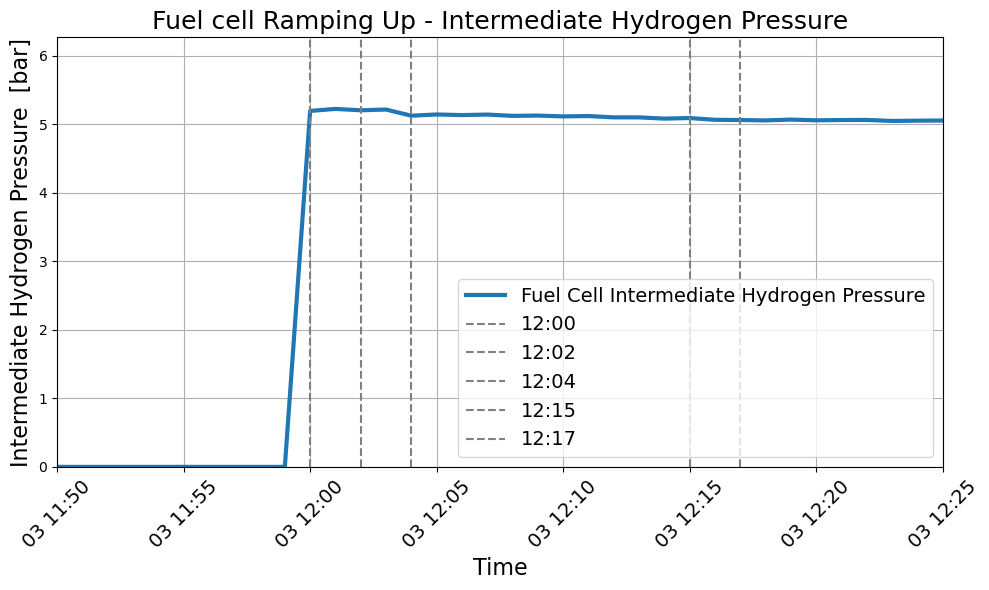

trimmed Fuel_Cell_Inverter_AC_Power for ramping up below:


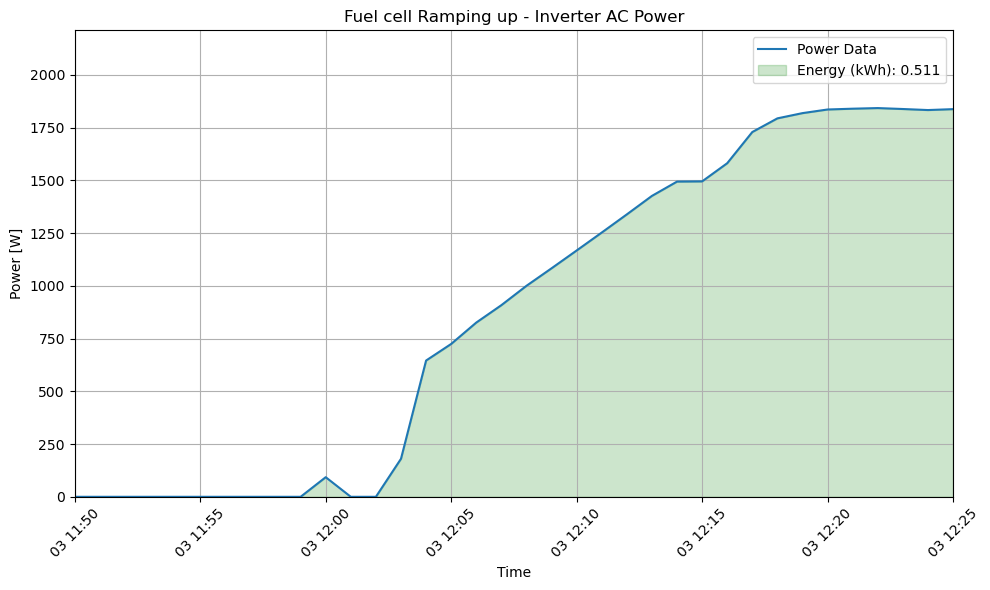

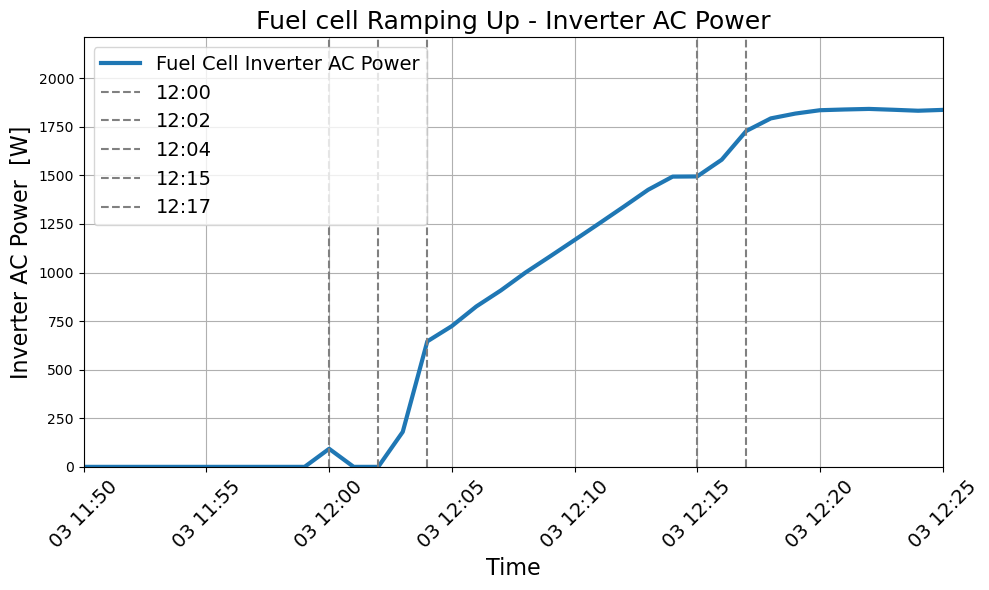

trimmed Fuel_Cell_Inverter_DC_Voltage for ramping up below:


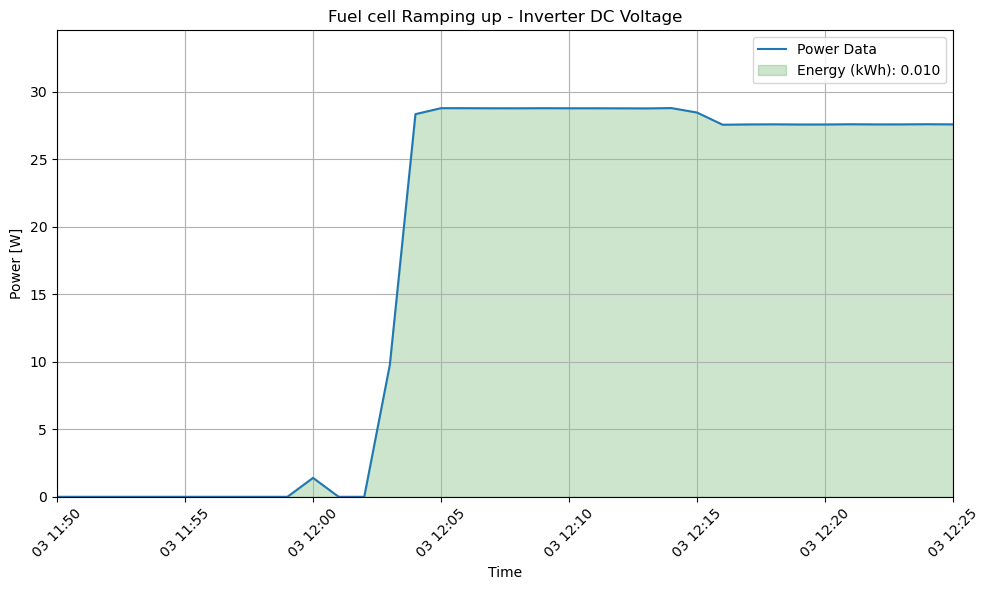

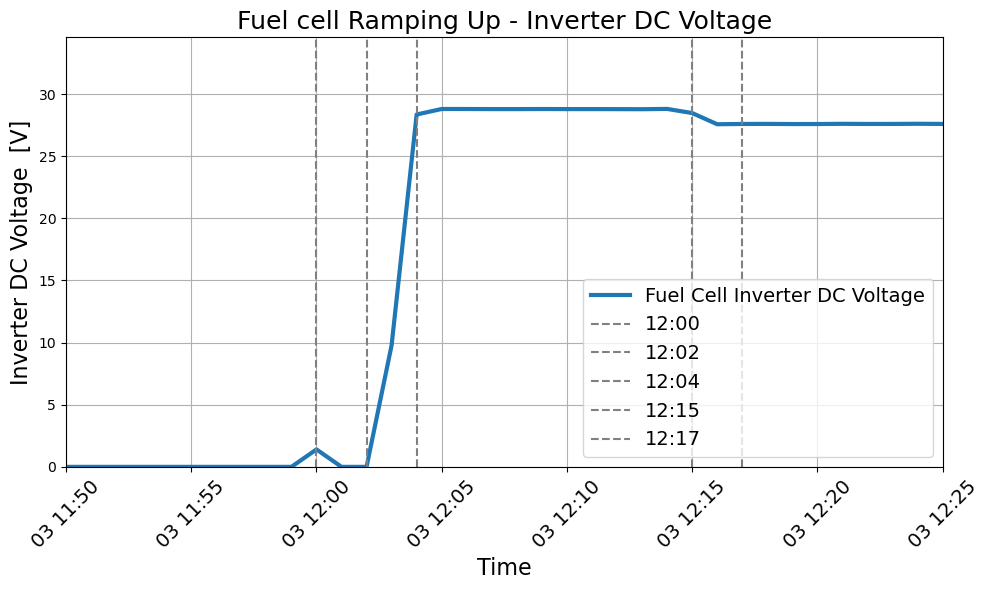

trimmed Fuel_Cell_Inverter_DC_Current for ramping up below:


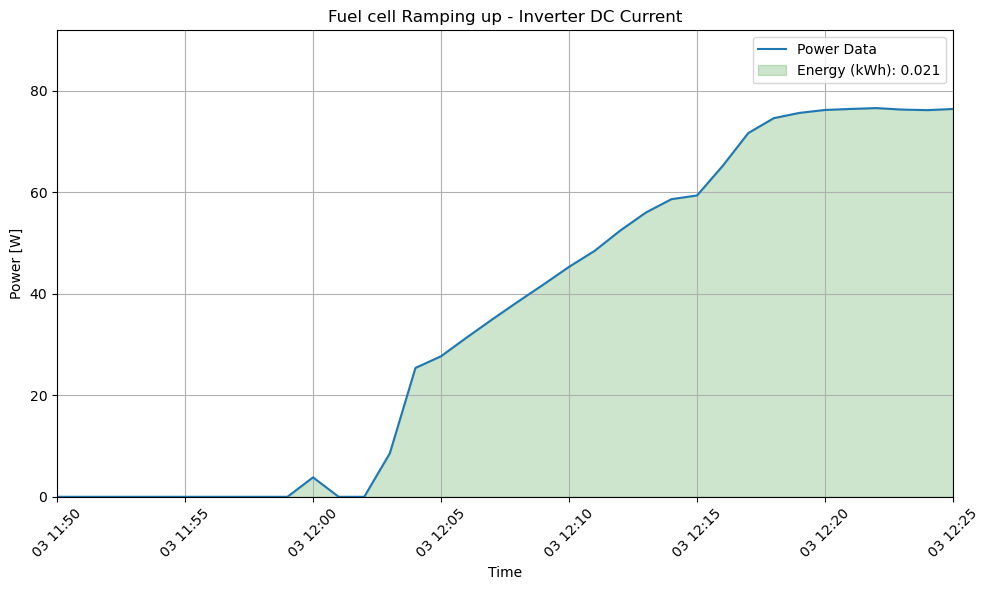

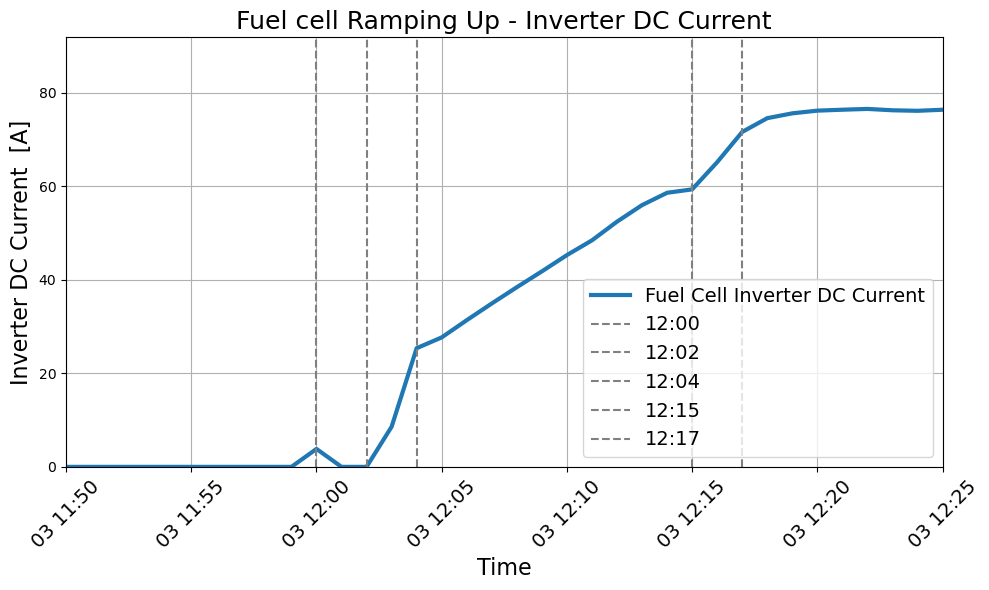

trimmed Fuel_Cell_MPPT_Output_Current for ramping up below:


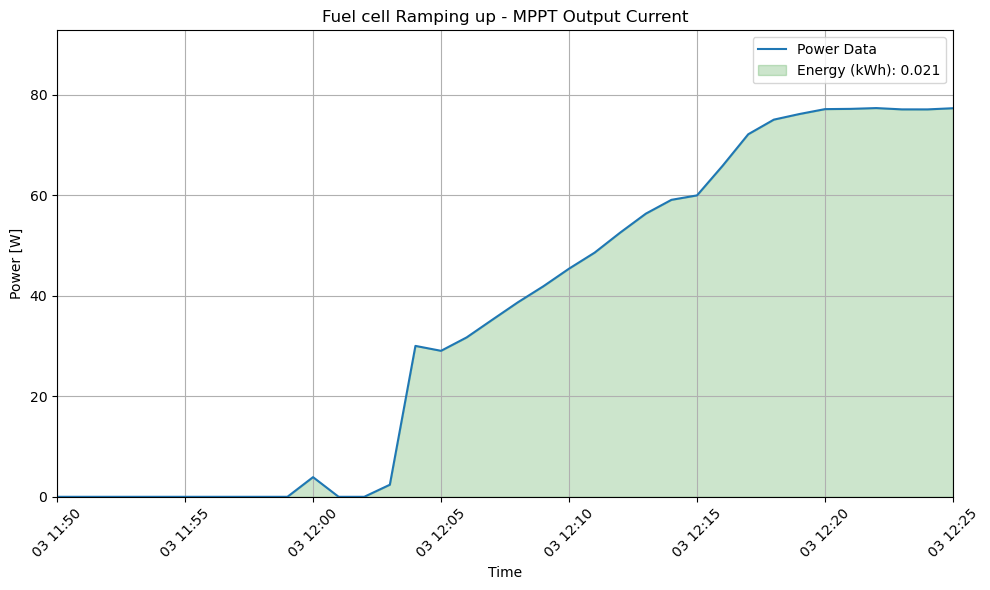

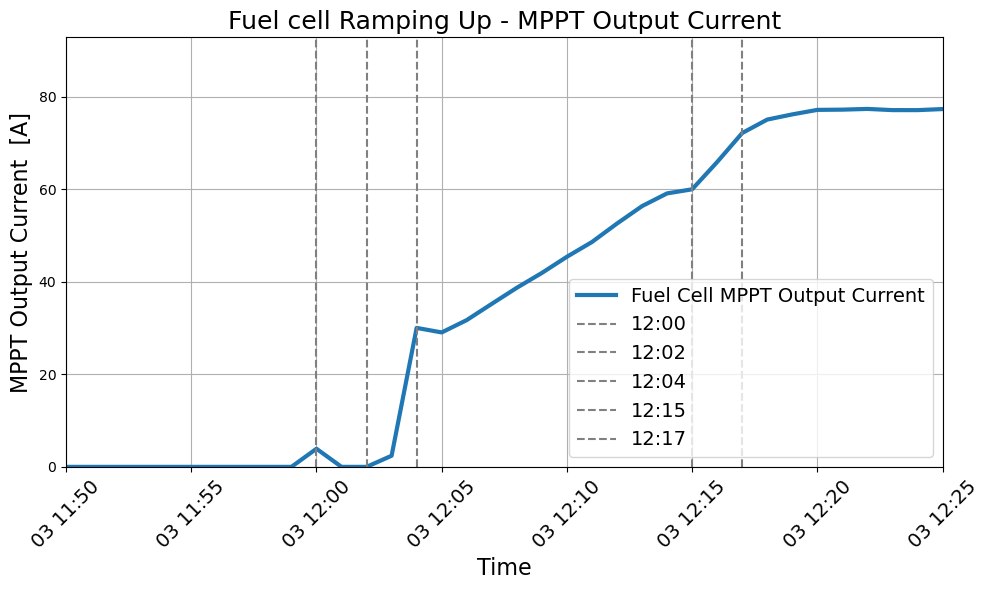

trimmed Fuel_Cell_MPPT_Output_Voltage for ramping up below:


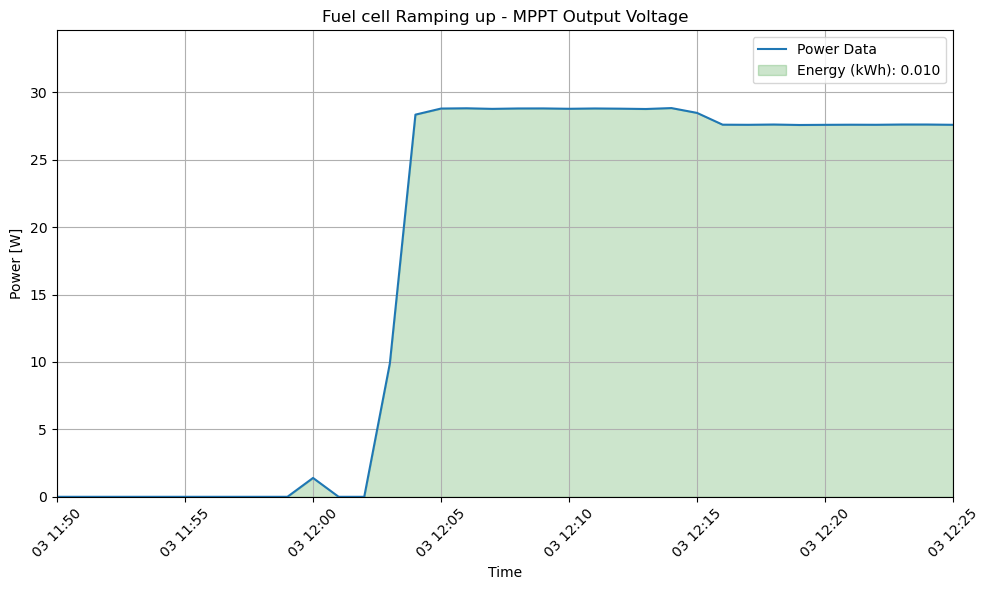

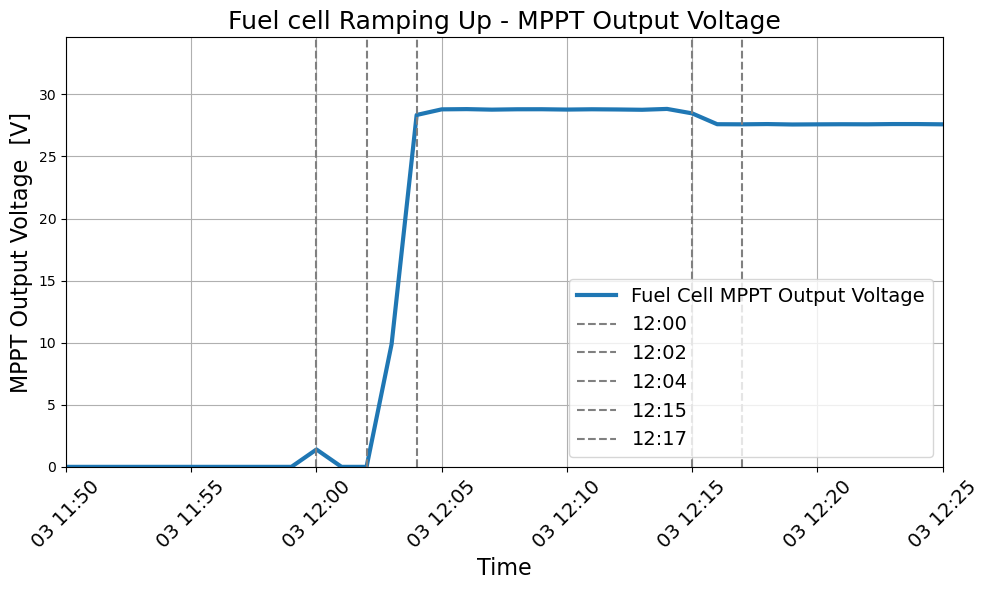

trimmed Fuel_Cell_Stack_DC_Voltage for ramping up below:


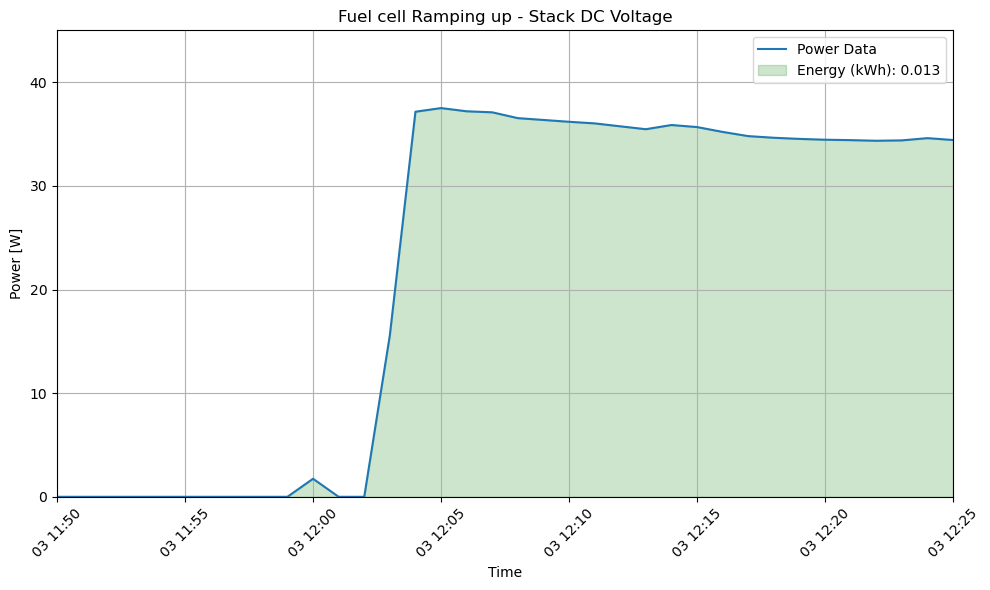

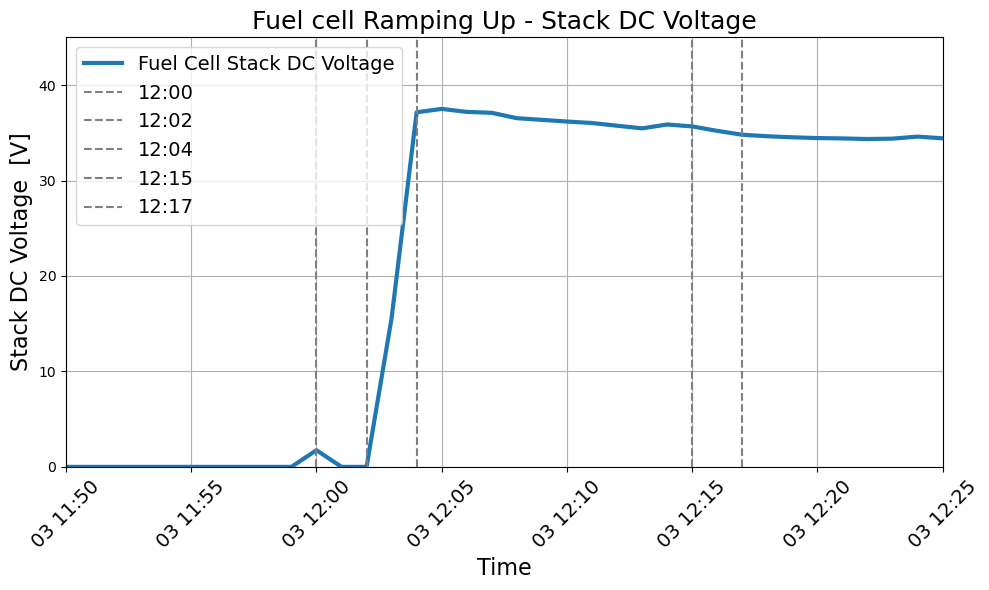

trimmed Fuel_Cell_Stack_DC_Current for ramping up below:


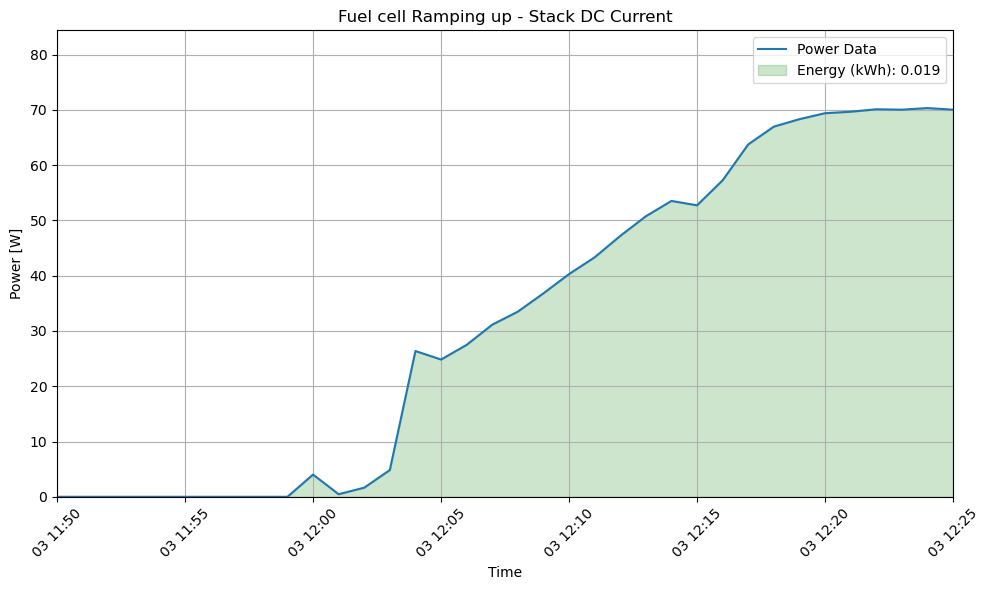

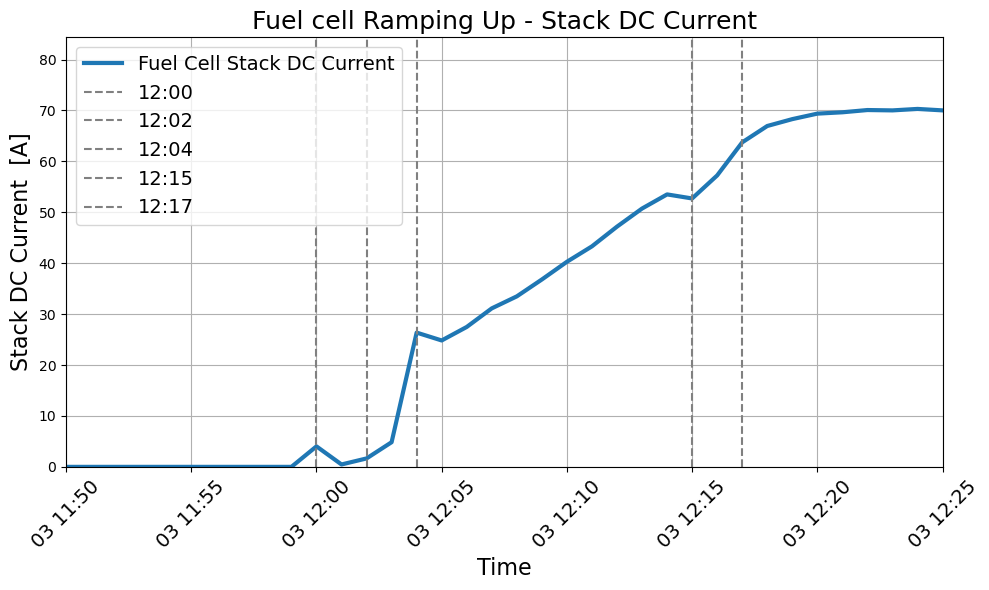

trimmed Fuel_Cell_Stack_Hydrogen_Inlet_Flow for ramping up below:


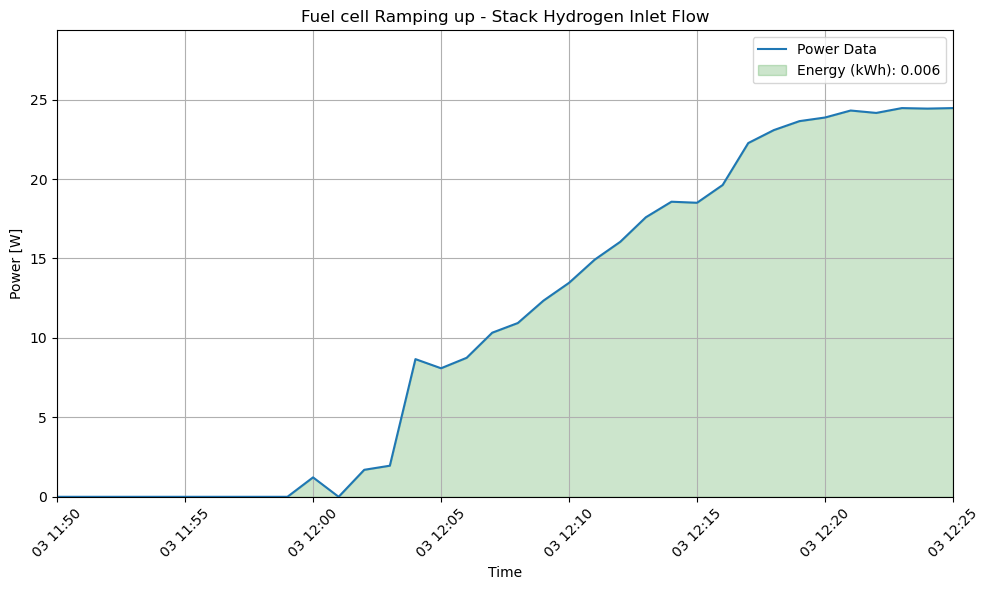

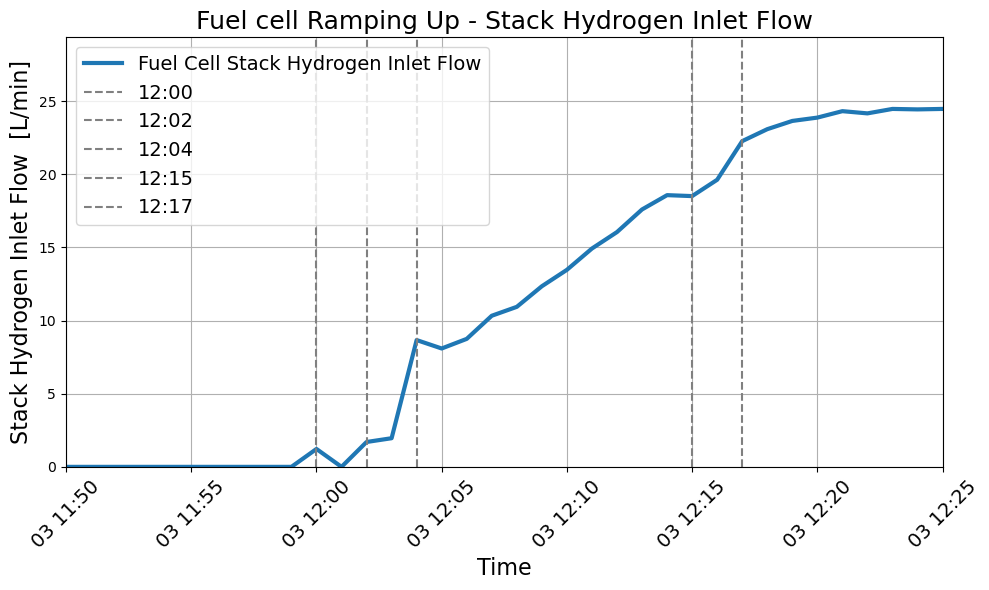

trimmed Battery_Inverter_AC_Out_Power for ramping up below:


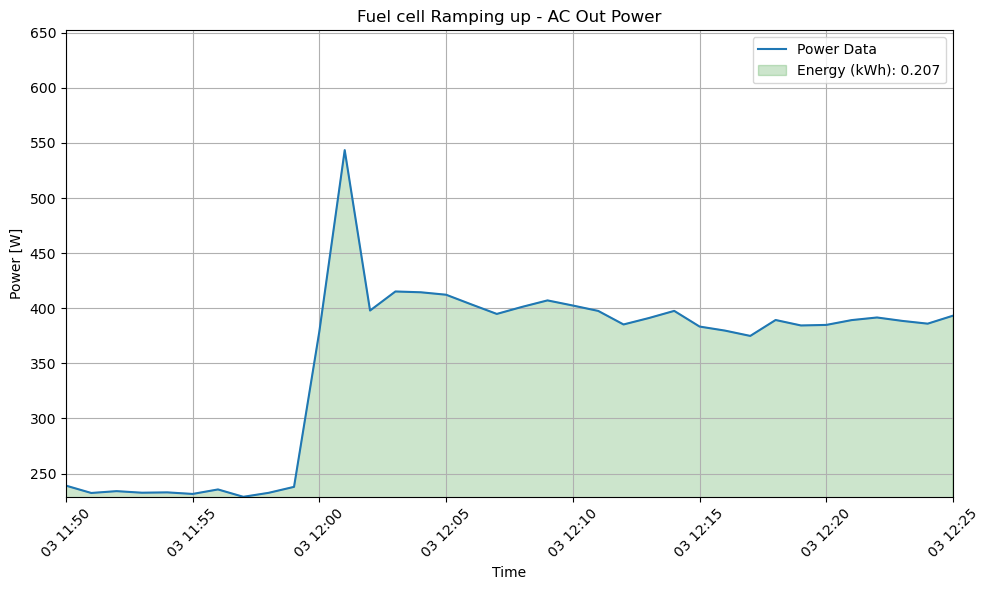

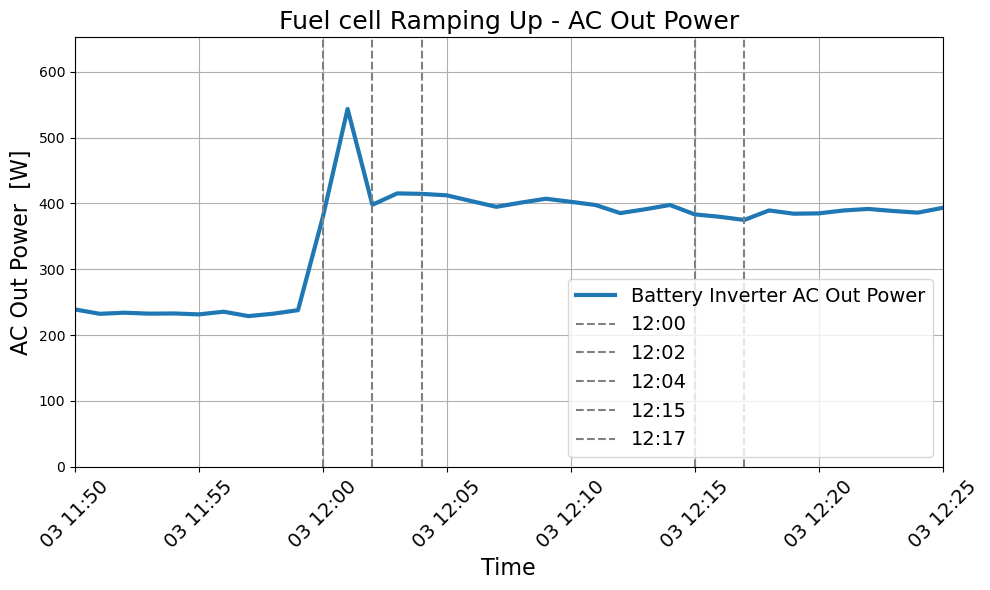




Results for ramping down:
trimmed Fuel_Cell_Fuel_Cell_Coolant_Flow for ramping down below:


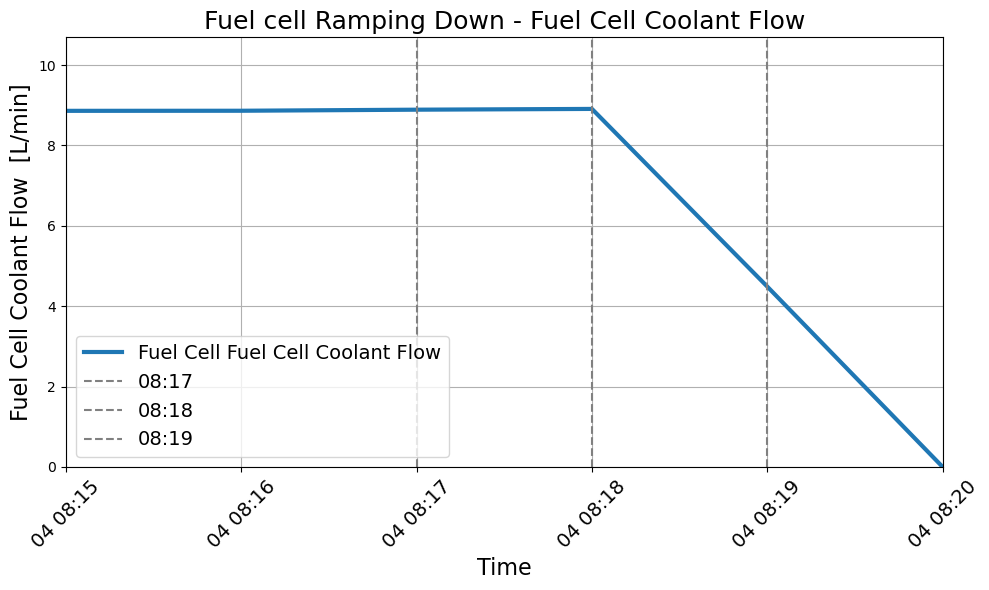

trimmed Fuel_Cell_Fuel_Cell_Coolant_Temperature_In for ramping down below:


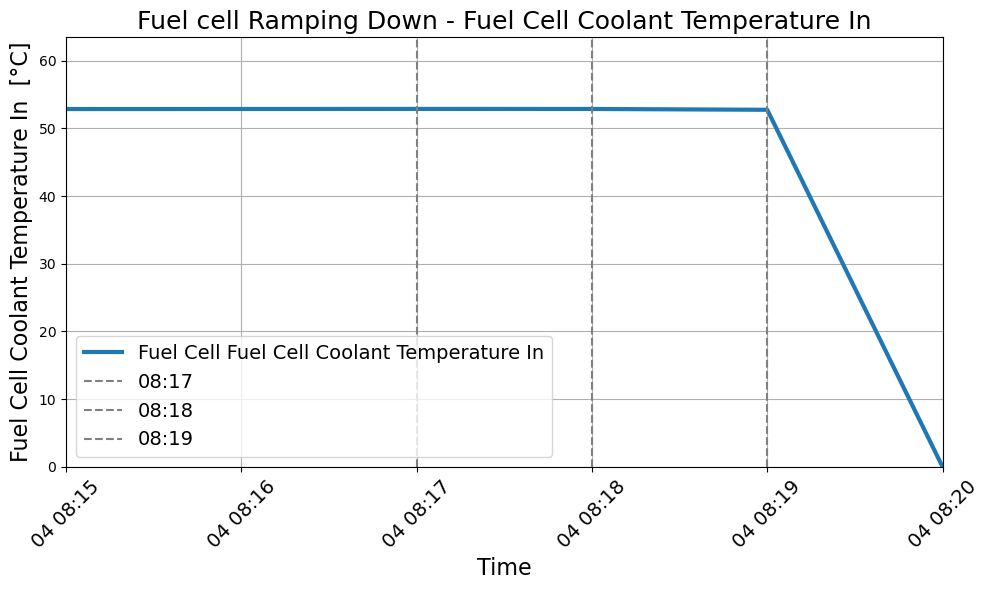

trimmed Fuel_Cell_Fuel_Cell_Coolant_Temperature_Out for ramping down below:


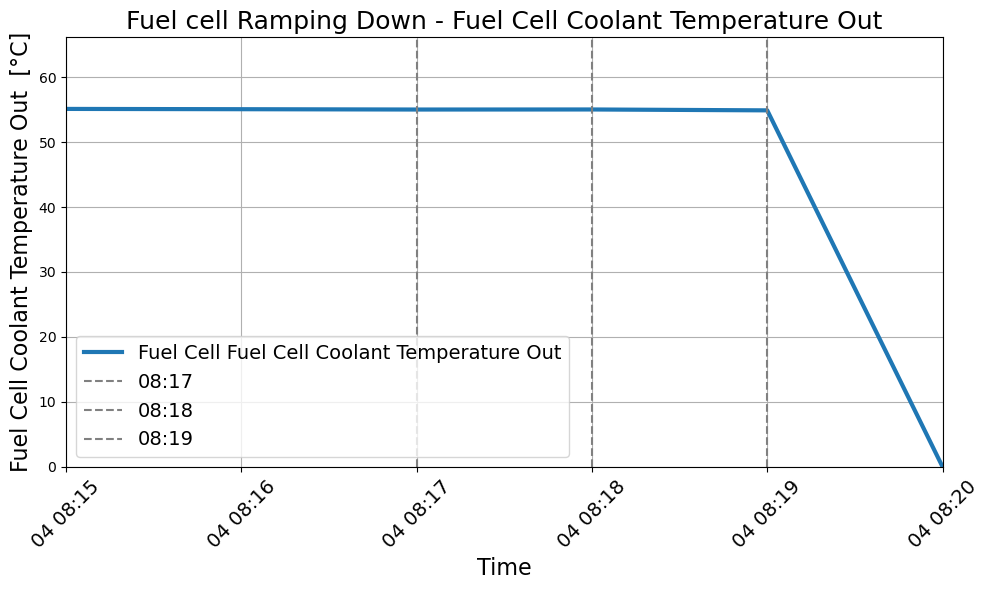

trimmed Fuel_Cell_Stack_Coolant_Flow for ramping down below:


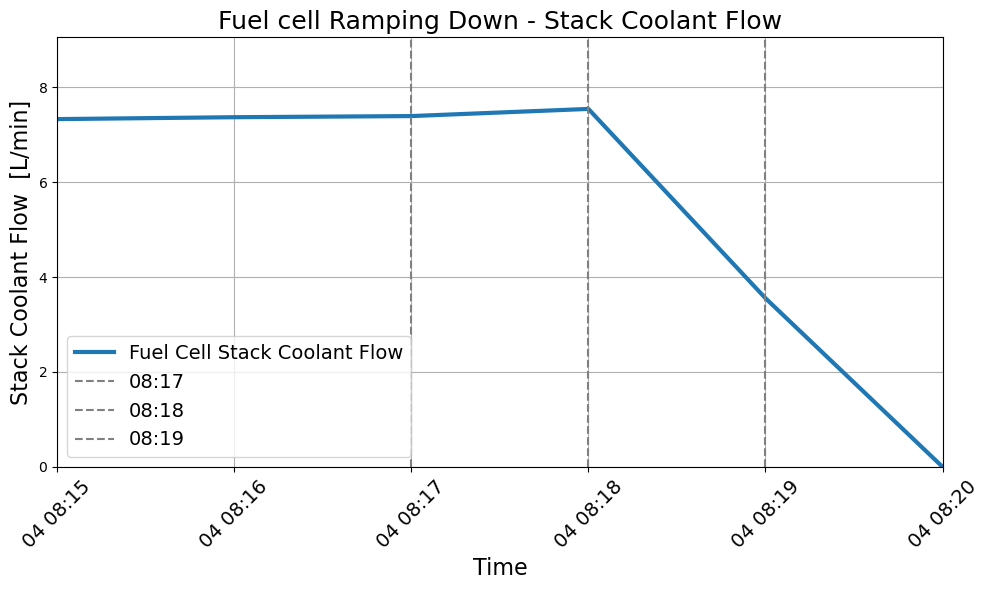

trimmed Fuel_Cell_Stack_Coolant_Temperature_In for ramping down below:


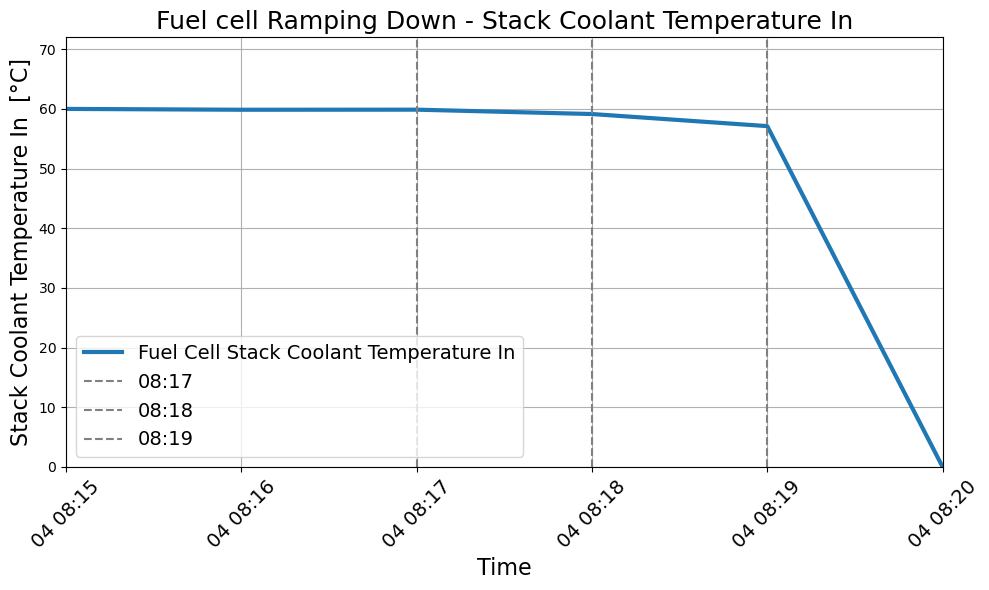

trimmed Fuel_Cell_Stack_Coolant_Temperature_Out for ramping down below:


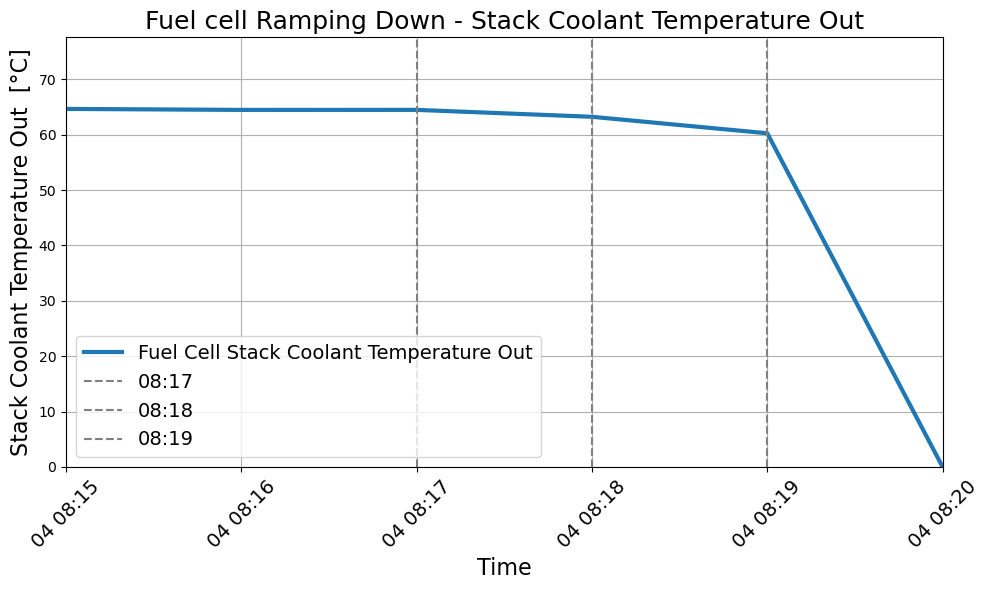

trimmed Fuel_Cell_Current_State for ramping down below:


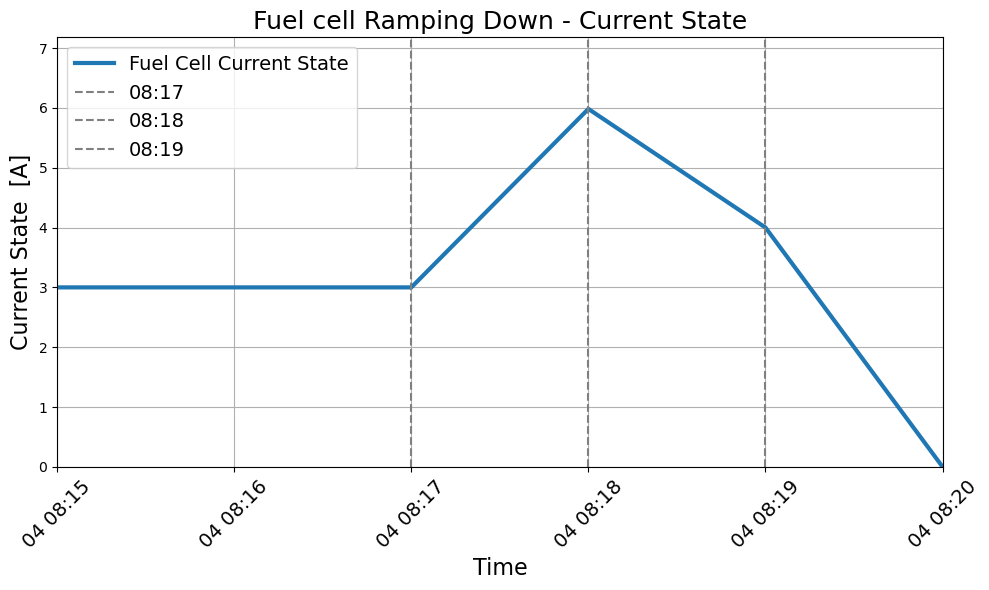

trimmed Pressure_Transmitter_State_Of_Charge for ramping down below:


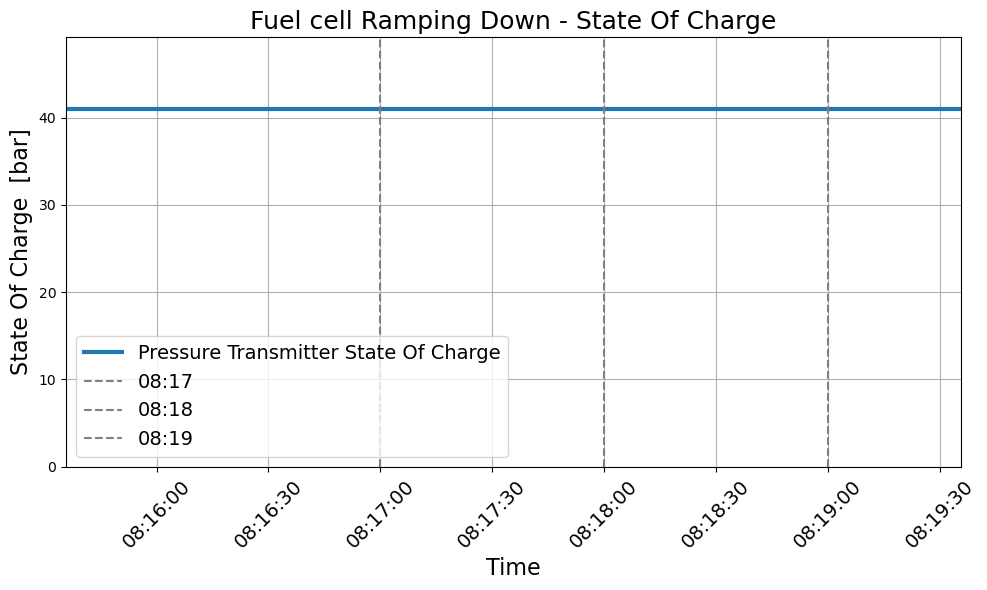

trimmed Battery_State_Of_Charge for ramping down below:


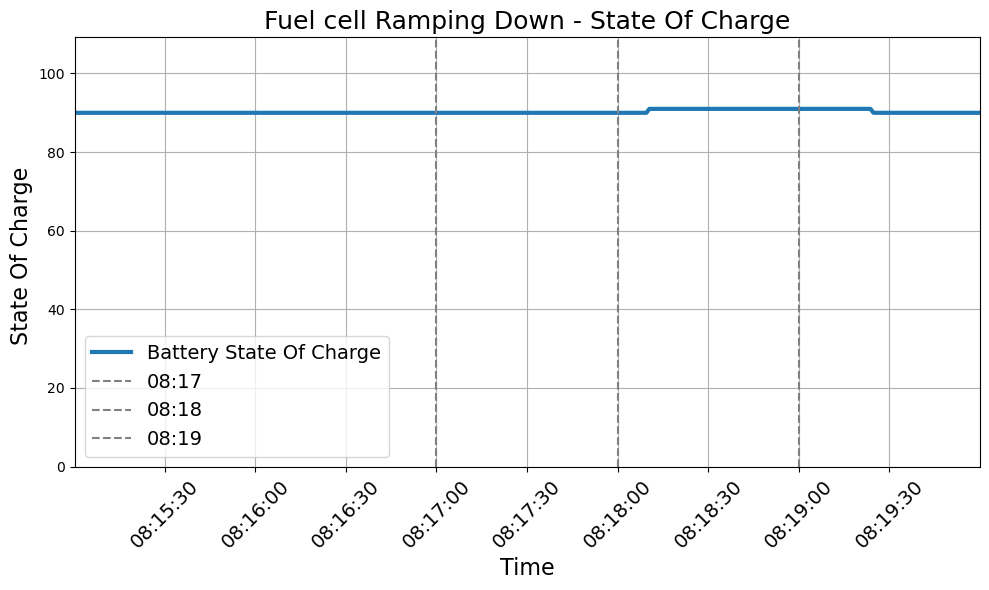

trimmed Fuel_Cell_Stack_Hydrogen_Pressure for ramping down below:


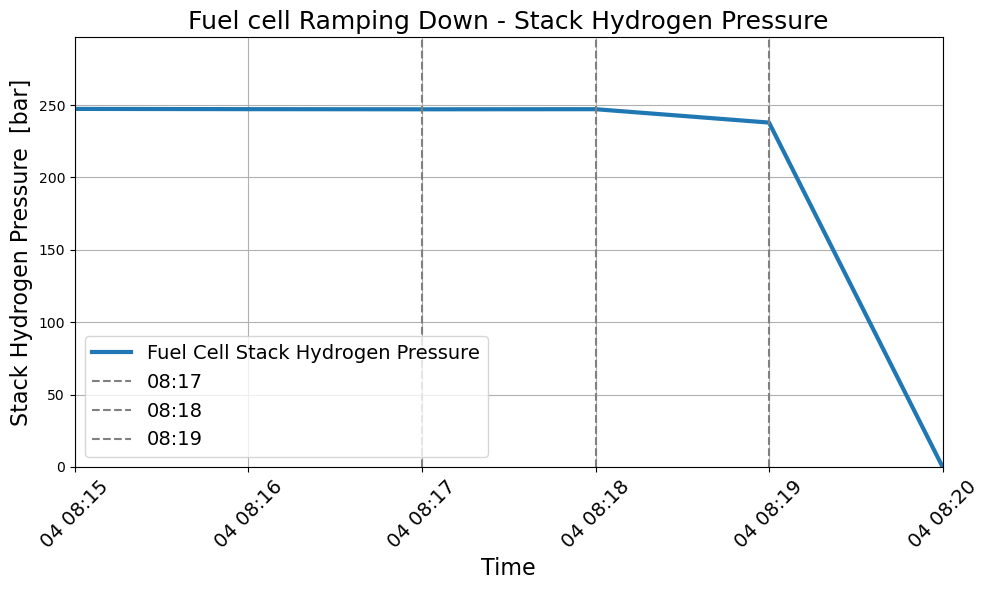

trimmed Fuel_Cell_Intermediate_Hydrogen_Pressure for ramping down below:


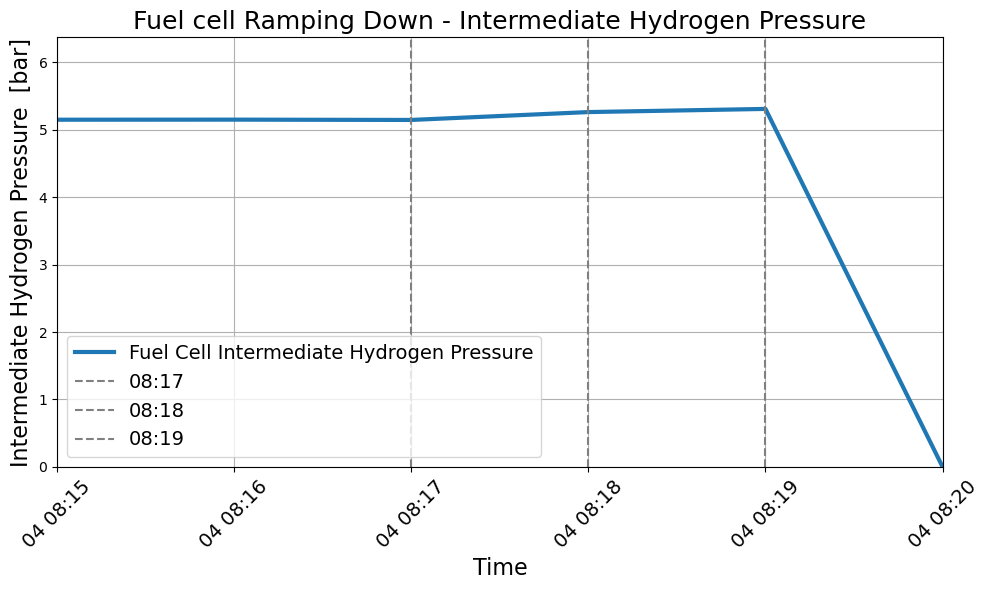

trimmed Fuel_Cell_Inverter_AC_Power for ramping down below:


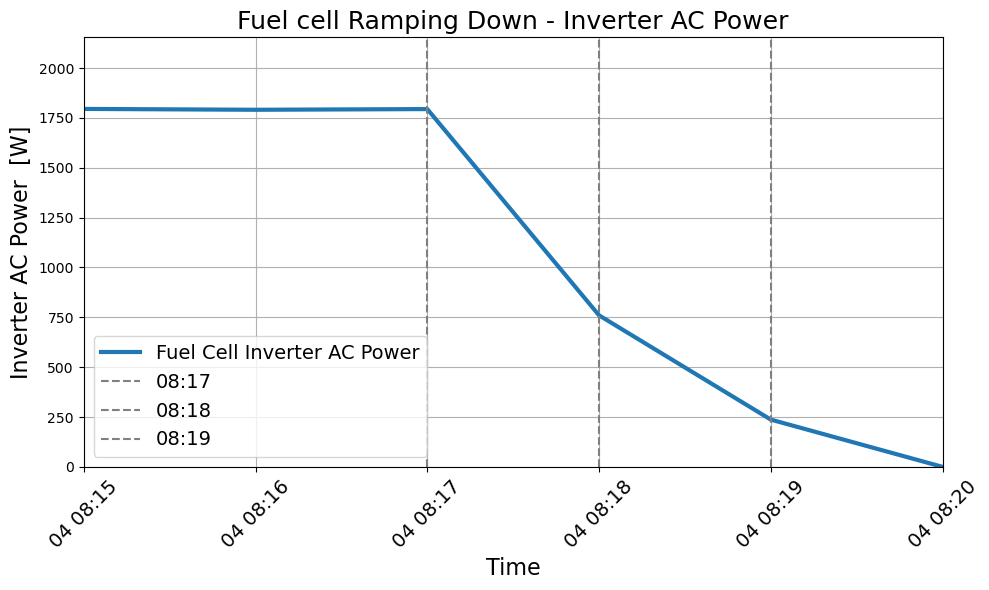

trimmed Fuel_Cell_Inverter_DC_Voltage for ramping down below:


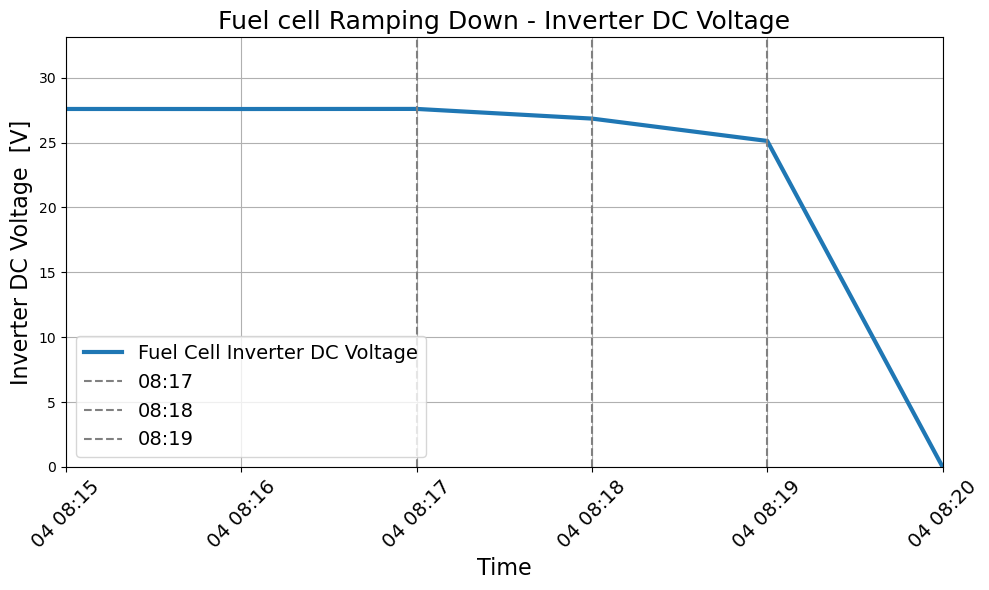

trimmed Fuel_Cell_Inverter_DC_Current for ramping down below:


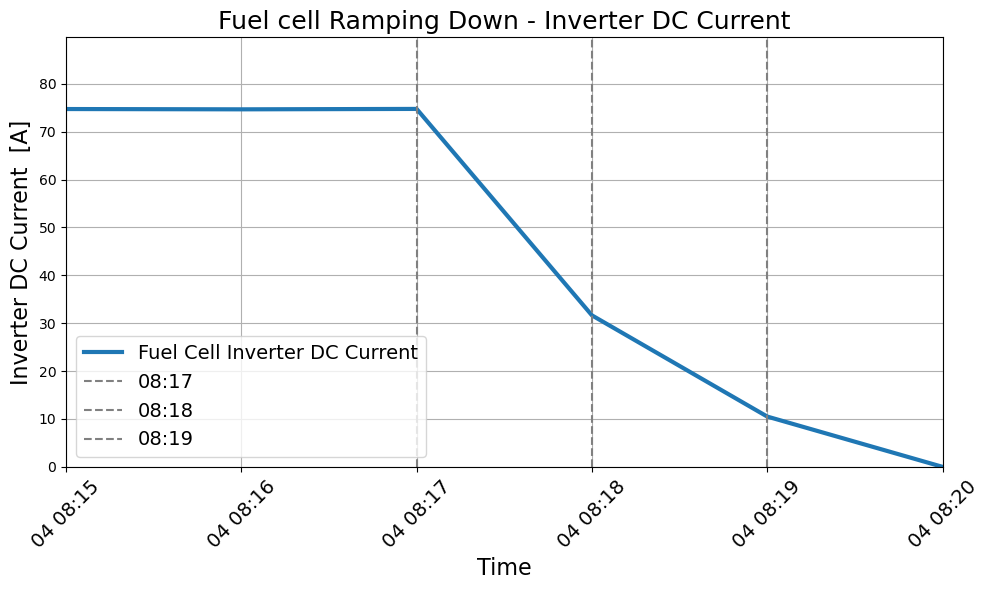

trimmed Fuel_Cell_MPPT_Output_Current for ramping down below:


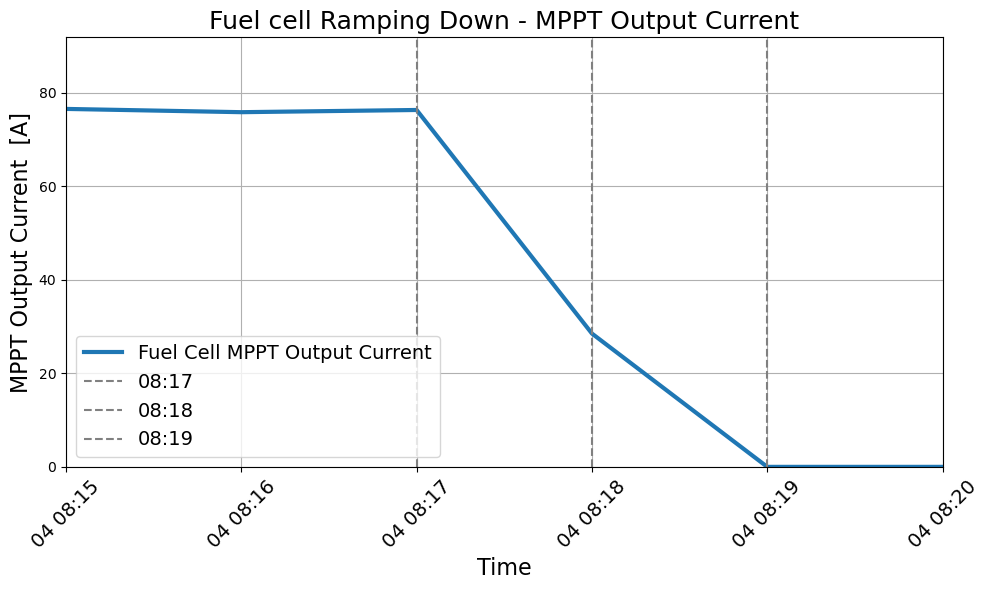

trimmed Fuel_Cell_MPPT_Output_Voltage for ramping down below:


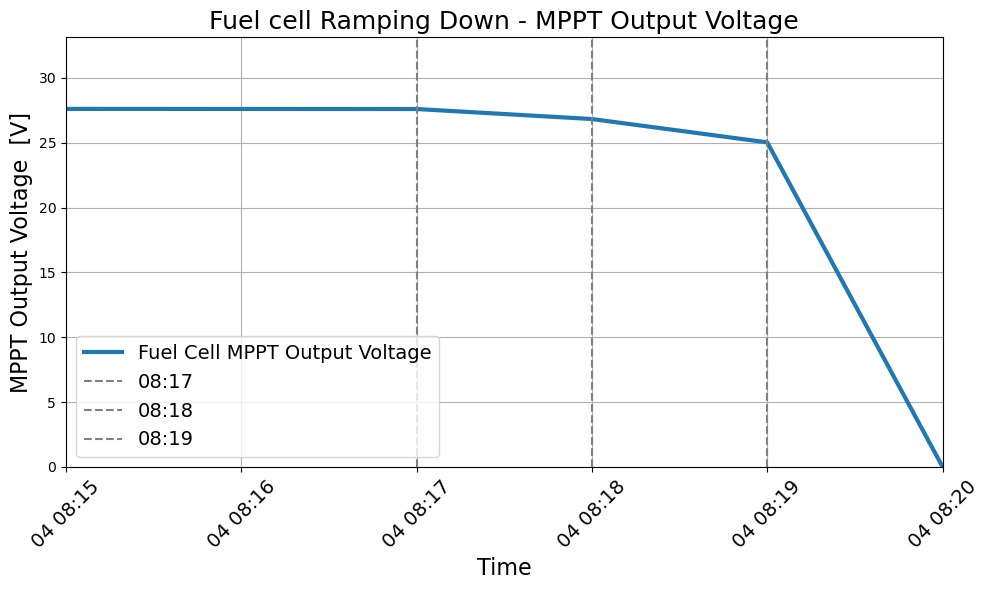

trimmed Fuel_Cell_Stack_DC_Voltage for ramping down below:


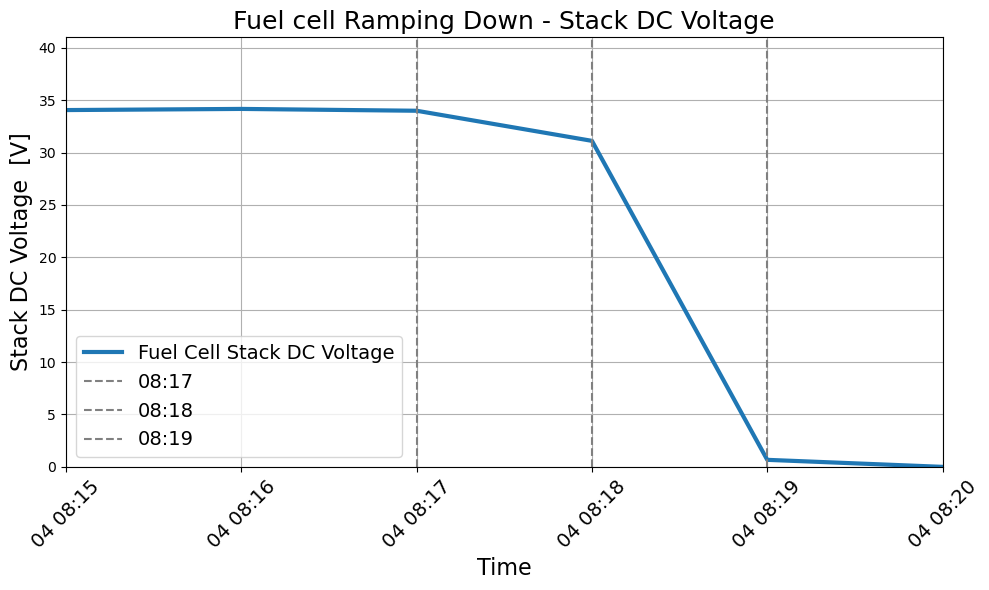

trimmed Fuel_Cell_Stack_DC_Current for ramping down below:


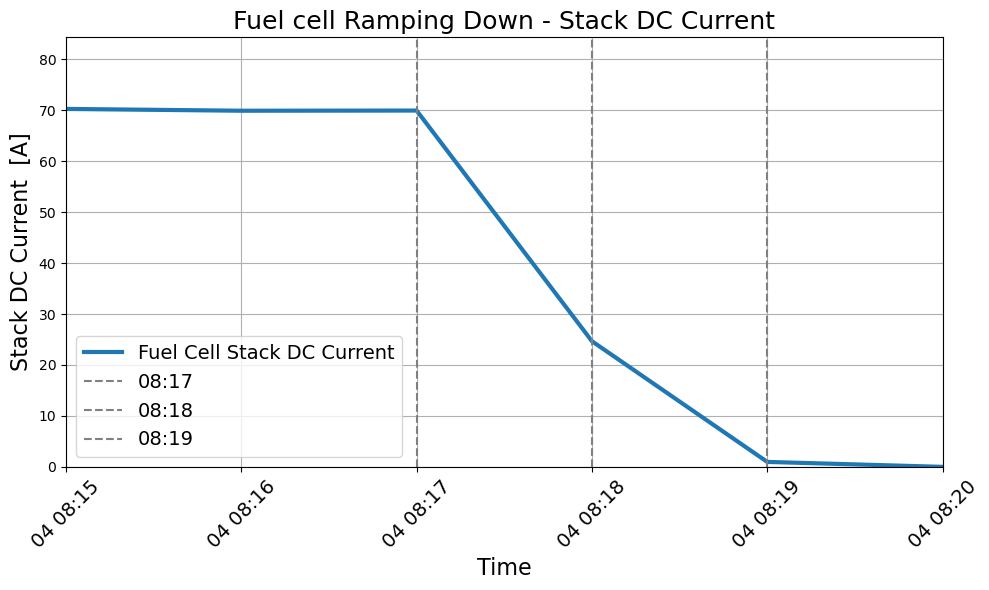

trimmed Fuel_Cell_Stack_Hydrogen_Inlet_Flow for ramping down below:


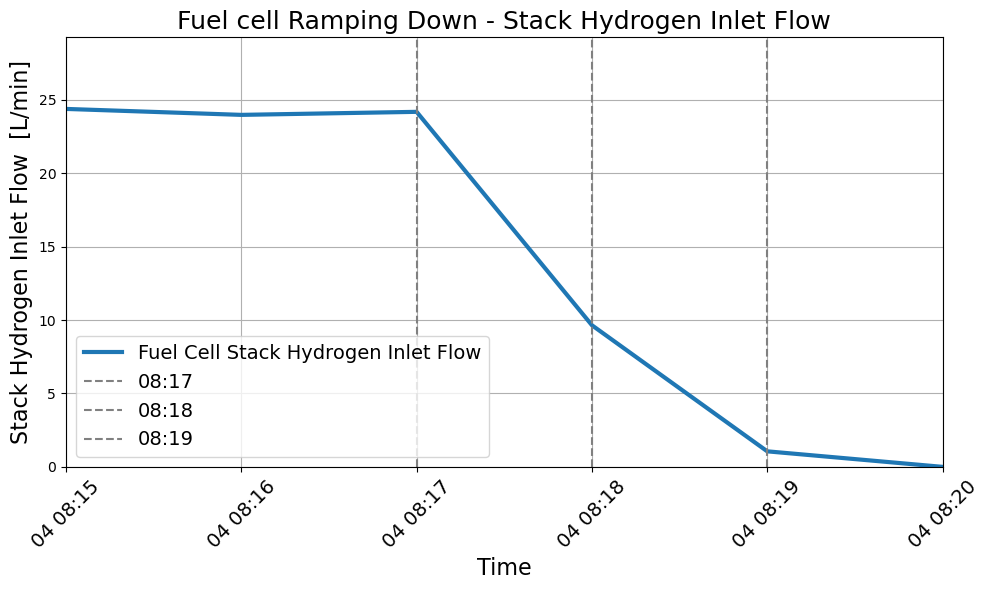

trimmed Battery_Inverter_AC_Out_Power for ramping down below:


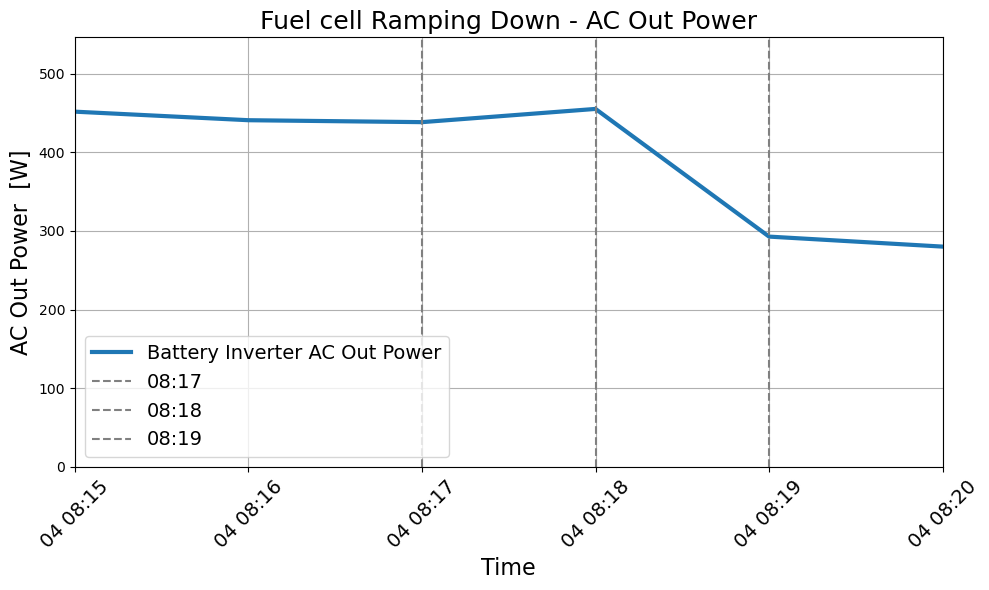

In [42]:

def trimrampup(var):
    data = globals()[var] # Needed to recall the data from their string name
    start_time = "2025-01-03 11:50:00"
    end_time = "2025-01-03 12:25:00"
    trimmed_name = f"{var}_trimmed"  # Create a unique variable name
    datatrimmed = data[(data['time'] >= start_time) & (data['time'] <= end_time)]
    globals()[trimmed_name] = datatrimmed  # Store dynamically named DataFrame
    integrate_hr_up(trimmed_name)
    fplotup(trimmed_name)
    return None

def trimrampdown(var):
    data = globals()[var] # Needed to recall the data from their string name
    start_time = "2025-01-04 08:15:00"
    end_time = "2025-01-04 08:20:00"
    trimmed_name = f"{var}_trimmed"  # Create a unique variable name
    datatrimmed = data[(data['time'] >= start_time) & (data['time'] <= end_time)]
    globals()[trimmed_name] = datatrimmed  # Store dynamically named DataFrame
    fplotdown(trimmed_name)
    return None

print('Results for ramping up:')

for var_name in DataframesToLoad:
    print(f"trimmed {var_name} for ramping up below:")
    trimrampup(var_name)


print()
print()
print()
print('Results for ramping down:')
for var_name in DataframesToLoad:
    print(f"trimmed {var_name} for ramping down below:")
    trimrampdown(var_name)




### Efficiency at rated power

In [10]:
LHV_H2 = 120000000 # J/kg
HHV_H2 = 142000000 # J/kg
MolarVolume = 22.414 # L/mol.
MolarMass = 2.016 # g/mol
H2Density = MolarMass/MolarVolume # g/L

Flow = 77 # NL/min
H2Power = LHV_H2*Flow*H2Density/(60*1000) # J/s
ElPower = 6.8e3;

print(f"The electrolyser efficiency is {ElPower/H2Power*100:.2f} % at full power")


The electrolyser efficiency is 49.09 % at full power
